# Kunskapskontroll SQL

Det ska gå att köra denna notebook i sin helhet så länge man har en lokal version av AdventureWorks installerad och har installerat paketen i requirements.txt. För att diagrammen för tabellrelationer ska få en hierarkisk layout krävs dock installation av tredjepartsprogramvaran graphviz. Jag har kört notebooken så att diagram visas så som det är tänkt att de ska se ut. Om notebooken ska köras för att kontrollera att allt fungerar och man inte har lust att installera graphviz så rekommenderas att man först läser genom och kollar på diagrammen och därefter kör igenom notebooken.

## Teoretiska frågor

#### 1. Beskriv kort hur en relationsdatabas fungerar

#### Svar:

Utmärkande för relationsdatabaser är att datan lagras i tabellform, d.v.s på rad/kolumn-format. Mellan tabellerna i databasen finns definierade relationer som gör det möjligt att koppla samman data från olika tabeller på ett smidigt sätt. Man använder en databashanterare för att interagera med databasen och det i särklass vanligaste språket som används för detta är någon dialekt av SQL. Några exempel på relationsdatabaser:

1. SqlServer
2. MySQL
3. PostgreSQL
4. Oracle Database

#### 2. Vad menas med CRUD-flödet?

#### Svar:

CRUD står för "Create", "Read", "Update", "Delete" och innefattar de operationer man göra på datan i en relationsdatabas. Nedan följer en förklaring av begreppen:

* Create - lägga till rader i en tabell (INSERT query)
* Read - läsa data från en tabell (SELECT query)
* Update - uppdatera existerande data i en tabell (UPDATE query)
* Delete - ta bort rader i en tabell (DELETE query)

Beroende på hur man utformar sin query kan CRUD-operationer påverka endast en eller flera rader i en tabell


#### 3. Beskriv kortfattat vad en "left join" och en "inner join" är. Varför använder man det?

#### Svar:

Både left joins och inner joins används för att kombinera data från en eller flera tabeller till en ny tabell. Man har alltid ett join-villkor (oftast likhet mellan kolumner) som måste uppfyllas för att två rader ska betraktas som matchande. Vid en left join behåller man alla rader i den vänstra tabellen (tabellen som nämns direkt efter FROM) även om de inte matchas av rader i den högra tabellen. För ickematchningar får man då null-värden på de kolumner som hör till den högra tabellen. Vid en inner join filtreras däremot rader som saknar matchning bort. För både left joins och inner joins gäller att om en rad i vänstertabellen matchar flera rader i högertabellen, kommer alla dessa rader med i resultattabellen. Exempel på såväl left joins som inner joins kan ses i programmeringsuppgiften nedan.

#### 4. Beskriv kortfattat vad indexering i SQL innebär.

#### Svar:

Indexering är ett sätt att snabba upp sökningar i tabeller. Utan indexering ligger datan fysiskt lagrad utan någon speciell ordning (heap) och tabellen måste därför sökas igenom rad för rad för att hitta alla matchningar. Om man använder sig av ett klustrat index, förändras lagringen på disk på ett sådan sätt att datan ligger ordnad i trädstruktur så att sökningar kan göras med logaritmisk tidskomplexitet. Eftersom klustrade index är beroende av hur datan är fysiskt lagrad kan man endast ha ett klustrat index. Om man istället använder sig av ett icke-klustrat index skapas istället (på disk) en separat trädstruktur där noderna innehåller referenser till var på disk den fysiska datan är lagrad för att snabba upp sökningar. Därför kan man ha flera icke-klustrade index. 

#### 5. Beskriv kortfattat vad en vy i SQL är.

#### Svar:

En vy är en virtuell tabell vars innehåll definieras av en query. I princip är en vy en lagrad query som körs varje gång man gör en query mot vyn. Vyer är användbara eftersom man då inte behöver skriva en komplex query varje gång man vill ha ett visst resultat utan kan istället skriva en query mot vyn som exekverar den lagrad komplexa queryn. De är också användbara för att begränsa tillgänglighet för användare. Inte alla användare ska kunna se samma data och det kan man lösa med vyer.

#### 6. Beskriv kortfattat vad en lagrad procedur i SQL är.

En lagrad procedur består av sparad kod som kan återanvändas. Det är möjligt att skicka parametrar i anropet till en lagrad procedur för att påverka exekveringsgången. Lagrade procedurer löser samma problem som vyer löser plus några till. Med lagrade procedurer är det möjligt att skriva DML och till och med DDL medan så inte är möjligt i vyer. Av denna anledning är lagrade procedurer vanliga i ETL-processer.

## Programmeringsuppgift

I programmeringsuppgiften har jag valt att skriva på engelska eftersom det blir mer naturligt när man blandar kodanrop med vanligt språkbruk. Jag har valt att lägga nästan all kod i några få celler eftersom jag skapar två klasser som sköter all funktionalitet. Därefter använder jag dessa klasser och dess metoder i själva analysdelen. Jag tycker det är bättre att göra så för då blir analysdelen mer sammanhängande och flyter på bättre. Vanligtvis hade jag förpassat all kod till moduler som jag sedan importerat och bara använt mig av anrop men för att underlätta rättning och presentation (och för att det står i uppgiften att vi ska göra så) så blir det kodblock direkt i notebooken.

### Database Description

#### Code blocks

##### SQL Queries

In [1]:
# A query for getting the schema names, table names and
# table row counts for those schemas that would be
# interesting for a normal user.
#
# In this query, we use the system views SYS.OBJECTS, 
# SYS.SCHEMAS and SYS.DM_DB_PARTITION_STATS which, among
# other things contain information about:
# 
# 1. SYS.OBJECTS - Information such as object type (table, view, etc), creation and modifcation times
# 2. SYS.SCHEMAS - schema names
# 3. SYS.DM_DB_PARTITION_STATS - Information about row counts for tables
sql_schemas="""
SELECT 
    T2.NAME SCHEMA_NAME
    ,T1.NAME TABLE_NAME
    ,TRIM(T1.TYPE) AS OBJECT_TYPE
    ,SUM(T3.ROW_COUNT) AS ROW_COUNT
FROM 
    SYS.OBJECTS T1
INNER JOIN -- Inner join here, since we are only interested in
           -- objects that belong to schemas. 
    SYS.SCHEMAS T2 
ON 
    T1.SCHEMA_ID = T2.SCHEMA_ID
LEFT JOIN -- Left join here, since we don't want to exclude views
    SYS.DM_DB_PARTITION_STATS T3 
ON 
    T1.OBJECT_ID = T3.OBJECT_ID
WHERE 
    T1.TYPE IN ('U', 'V') -- We are only interested in user tables and views
AND 
    (T3.INDEX_ID IN (0, 1) OR T1.TYPE = 'V') -- We are only interested in row counts in the actual physical storage of
                                             -- data. Excluding other indexes achieves this.
AND
    T2.NAME NOT IN (
        'sys', 
        'INFORMATION_SCHEMA', 
        'dbo', 
        'guest', 
        'db_accessadmin', 
        'db_backupoperator', 
        'db_datareader', 
        'db_datawriter', 
        'db_ddladmin', 
        'db_denydatareader', 
        'db_denydatawriter', 
        'db_owner', 
        'db_securityadmin'
    )
GROUP BY 
        T2.NAME
    ,T1.NAME
    ,T1.TYPE
;        
"""

# A CTE query for getting the foreign key relations between tables in the schemas
# that are relevant for a normal user. 
#
# In this query, we use the following system views:
#
# 1. SYS.TABLES - Information about tables such as name, type, creation time etc
# 2. SYS.SCHEMAS - Schema names
# 3. SYS.FOREIGN_KEYS - Information such as the name of the key, which table it 
#    points to, creation date etc
# 4. SYS.FOREIGN_KEY_COLUMNS - Information about columns associated with the 
#                              foreign key constraint
# 5. SYS.COLUMNS - Information about columns in general such as name, data type, 
#                  precision etc
#
sql_relations="""
/*
    Step 1 - get information about relevant tables
*/
WITH TABS AS (
SELECT
    T2.NAME SCHEMA_NAME
    ,T1.NAME TABLE_NAME
    ,T1.OBJECT_ID
FROM 
    SYS.TABLES T1
INNER JOIN
    SYS.SCHEMAS T2
ON
    T1.SCHEMA_ID = T2.SCHEMA_ID
WHERE -- Exclude non interesting schemas
    T2.NAME NOT IN (
        'sys', 
        'INFORMATION_SCHEMA', 
        'dbo', 
        'guest', 
        'db_accessadmin', 
        'db_backupoperator', 
        'db_datareader', 
        'db_datawriter', 
        'db_ddladmin', 
        'db_denydatareader', 
        'db_denydatawriter', 
        'db_owner', 
        'db_securityadmin'
    )
/*
    Step 2 - get information about foreign key relatations.
             It's inner joins all the way here since we want
             only mathces.
*/
), FORKEYS AS(
SELECT
    T7.NAME SCHEMA_NAME
    ,T5.NAME TABLE_NAME
    ,T6.NAME COLUMN_NAME
    ,T8.NAME IS_REFERENCED_BY_SCHEMA_NAME
    ,T3.NAME IS_REFERENCED_BY_TABLE_NAME
    ,T4.NAME IS_REFERENCED_BY_COLUMN_NAME
    ,T1.NAME VIA_FOREIGN_KEY_NAME

FROM
    SYS.FOREIGN_KEYS T1
INNER JOIN
    SYS.FOREIGN_KEY_COLUMNS T2 
ON 
    T1.OBJECT_ID = T2.CONSTRAINT_OBJECT_ID
INNER JOIN
    SYS.TABLES T3
ON 
    T2.PARENT_OBJECT_ID = T3.OBJECT_ID
INNER JOIN
    SYS.COLUMNS T4
ON 
    T2.PARENT_OBJECT_ID = T4.OBJECT_ID AND T2.PARENT_COLUMN_ID = T4.COLUMN_ID
INNER JOIN
    SYS.TABLES T5
ON 
    T2.REFERENCED_OBJECT_ID = T5.OBJECT_ID
INNER JOIN
    SYS.COLUMNS T6
ON 
    T2.REFERENCED_OBJECT_ID = T6.OBJECT_ID AND T2.REFERENCED_COLUMN_ID = T6.COLUMN_ID
INNER JOIN
    SYS.SCHEMAS T7
ON 
    T5.SCHEMA_ID = T7.SCHEMA_ID
INNER JOIN
    SYS.SCHEMAS T8
ON
    T3.SCHEMA_ID = T8.SCHEMA_ID
)
/*
    Final step - Gather the needed data from the temp tables.
                 We use a left join here since we want to keep
                 those tables in the schema that do not have
                 any relationships with other tables.
*/
SELECT
    T1.SCHEMA_NAME
    ,T1.TABLE_NAME
    ,T2.COLUMN_NAME
    ,T2.IS_REFERENCED_BY_SCHEMA_NAME
    ,T2.IS_REFERENCED_BY_TABLE_NAME
    ,T2.IS_REFERENCED_BY_COLUMN_NAME
    ,T2.VIA_FOREIGN_KEY_NAME
FROM
    TABS T1
LEFT JOIN -- Left join here since we want to keep
          -- tables that have no relationsships
    FORKEYS T2
ON
    T1.SCHEMA_NAME = T2.SCHEMA_NAME
AND
    T1.TABLE_NAME = T2.TABLE_NAME
ORDER BY
    T1.SCHEMA_NAME, CASE WHEN COLUMN_NAME IS NULL THEN 0 ELSE 1 END, TABLE_NAME
;
"""

##### The DatabaseDescriptor Class

In [2]:
# Perform necessary imports
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx

# Set seaborn theme and context
sns.set_theme(style="darkgrid")  
sns.set_context(context="notebook")

class DatabaseDescriptor:
    """
    A class for getting information about a database.

    This class provides funktionality for generating a quick overview of the schemas, 
    tables, views and relations between tables in a database.

    Attributes:
        engine:                     sqlalchemy.engine.base.Engine
        schema_tables_views_df:     pandas.core.frame.DataFrame
        view_counts_df:             pandas.core.frame.DataFrame
        table_counts_df             pandas.core.frame.DataFrame
        relations_df:               pandas.core.frame.DataFrame

    Methods:
        plot_schemas:                                                Display two bar charts: Table counts by
                                                                                             schema and view
                                                                                             counts by schema
        plot_schema(schema_name):                                    Display a bar chart: Row counts by table
        
        plot_schema_relations(schema_name): Display a network chart: Foreign key relations between tables
    """
    def __init__(self,connection_string: str):
        # Set up the connection to the database, perform queries and load 
        # results into dataframes.     
        self.engine = create_engine(connection_string)
        (
            self.schema_tables_views_df, 
            self.view_counts_df, 
            self.table_counts_df,
            self.relations_df 
        ) = self.__get_schema_table_view_dfs__()
        
    def plot_schemas(self):
        """
        Display two bar charts: table count by schema and view count by schema
        """
        fig,axes = plt.subplots(1,2,figsize=(12,5))
        # Sort the table_counts dataframe to get the largest tables
        # at the top in the bar chart
        df=self.table_counts_df.sort_values(by='TABLE_COUNT',ascending=False)
        # Create the bar chart for the tables
        sns.barplot(
            data=df,
            x="TABLE_COUNT", 
            y="SCHEMA_NAME",
            palette = sns.light_palette("navy", reverse=True, as_cmap=False,n_colors=len(df)),
            edgecolor=".2",
            hue='SCHEMA_NAME',
            legend=False,
            ax=axes[0]
        )
        axes[0].set_xlabel('TABLE COUNT')
        axes[0].set_ylabel('SCHEMA NAME')
        axes[0].set_title('TABLE COUNT BY SCHEMA')
        # Sort the view_counts dataframe to get the largest views
        # at the top in the bar chart
        df=self.view_counts_df.sort_values(by='VIEW_COUNT',ascending=False)
        # Create the bar chart for the views
        sns.barplot(
            data=df, 
            x="VIEW_COUNT", 
            y="SCHEMA_NAME",
            palette = sns.light_palette("navy", reverse=True, as_cmap=False,n_colors=len(df)),
            edgecolor=".2",
            hue='SCHEMA_NAME',
            legend=False,
            ax=axes[1]
        )
        axes[1].set_xlabel('VIEW COUNT')
        axes[1].set_ylabel('SCHEMA NAME')
        axes[1].set_title('VIEW COUNT BY SCHEMA')
        # Make sure nothing falls outside the figure
        plt.tight_layout()
        plt.show()

    def plot_schema(self,schema_name: str):
        """
        Display a bar chart: row count by table name

        Arguments:
            schema_name: str
        """
        # Filter the schema_tables_views_df so that we only concern
        # ourselves with tables from the schema given in the argument
        # Also, sort the result to get the tables with the largest
        # row counts on top in the bar chart.
        df=self.schema_tables_views_df[
            (
                (self.schema_tables_views_df['SCHEMA_NAME']==schema_name) & 
                (self.schema_tables_views_df['OBJECT_TYPE']=='U')
            )
        ].sort_values(by='ROW_COUNT',ascending=False)

        fig,ax=plt.subplots(figsize=(10,5))
        # Create the bar chart
        sns.barplot(
            data=df, 
            x="ROW_COUNT", 
            y="TABLE_NAME",
            palette = sns.light_palette("navy", reverse=True, as_cmap=False,n_colors=len(df)),
            edgecolor=".2",
            hue='TABLE_NAME',
            legend=False
        )
        ax.set_xlabel('ROW COUNT')
        ax.set_ylabel('TABLE NAME')
        ax.set_title(f'ROW COUNT BY TABLE FOR SCHEMA {schema_name}')
        # If the table counts are sufficiently large, it's better to have
        # logarithmic scaling on the row count axis
        if df['ROW_COUNT'].max() > 10**4:
            plt.xscale('log')
        
        plt.show()
    
    def plot_schema_relations(self,schema_name):
        """
        Display a network graph of the foreign key relationships
        for tables in a schema.

        Arguments:
            schema_name: str
        """
        df = self.relations_df[self.relations_df['SCHEMA_NAME'] == schema_name]
        G,pos,node_color_list = self.__build_network_graph__(df,schema_name)
        
        plt.figure(figsize=(25, 8))
        nx.draw(
            G, 
            pos, 
            with_labels=True, 
            node_size=4000, 
            node_color=node_color_list, 
            font_size=12, 
            font_weight='bold', 
            edge_color='gray', 
            linewidths=2, 
            arrowsize=25, 
            arrowstyle='-|>'
        )

        plt.title(f"TABLE RELATIONS FOR SCHEMA {schema_name}", fontsize=18, fontweight='bold')
        plt.show()

    def __build_network_graph__(self, df: pd.core.frame.DataFrame,schema_name: str) -> tuple:
        # Initialize a dictionary that will hold information about
        # the color of teach node in the graph
        node_colors = {}
        # Initialize a graph
        G = nx.DiGraph()
        # Create the nodes/edges of the graph and determine node color
        for idx, row in df.iterrows():
            table_name = row['TABLE_NAME']
            G.add_node(table_name)
            node_colors[table_name]='skyblue'
            referenced_table_name = row['IS_REFERENCED_BY_TABLE_NAME']
            # It may be the case that the current table has no relationsships
            # with other tables, so we must check this before proceeding.
            if pd.notna(referenced_table_name):
                G.add_node(referenced_table_name)
                # It may be the case that the current referenced table
                # doesn't belong to the schema we are interested in.
                # If this is so, we want to reflect this fact by having
                # the node taking a different color.
                if row['IS_REFERENCED_BY_SCHEMA_NAME'] != schema_name:
                    node_colors[referenced_table_name] = 'red'
                else:
                    node_colors[referenced_table_name] = 'skyblue'
                G.add_edge(referenced_table_name,table_name)
        
        # Position the nodes and edges (for drawing purposes)
        # We wan't a hierarchical layout for the graph. For 
        # this, graphviz needs to be installed, which may not
        # be the case. We'll try to use it and if it doesn't
        # work we'll revert back to the default layout
        try:
            pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
            pos = {node: (x, -y) for node, (x, y) in pos.items()}
        except ImportError:
            pos = nx.spring_layout(G)
        # Make sure the color information is in a type suitable
        # for nx.draw
        node_color_list = [node_colors[node] for node in G.nodes]
        
        return G,pos,node_color_list

        
    def __get_schema_table_view_dfs__(self) -> tuple:
        # Connect to the database, execute the queries
        # and load information into dataframes
        with self.engine.connect() as conn:            
            schema_tables_views=pd.read_sql(sql_schemas,conn)
            table_counts = schema_tables_views[
                schema_tables_views['OBJECT_TYPE']=='U'
            ].groupby("SCHEMA_NAME").size().reset_index(name="TABLE_COUNT")
            view_counts = schema_tables_views[
                schema_tables_views['OBJECT_TYPE']=='V'
            ].groupby("SCHEMA_NAME").size().reset_index(name="VIEW_COUNT")            
            relations = pd.read_sql(sql_relations,conn)
            return schema_tables_views,view_counts,table_counts,relations
conn_str = f"mssql+pyodbc://localhost/AdventureWorks2022?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&TrustServerCertificate=yes"
d=DatabaseDescriptor(conn_str)

### Description of the AdventureWorks database

### Schemas

There are 5 schemas of interest to most users. The schemas and their respective table- and view counts can be seen in the image below.

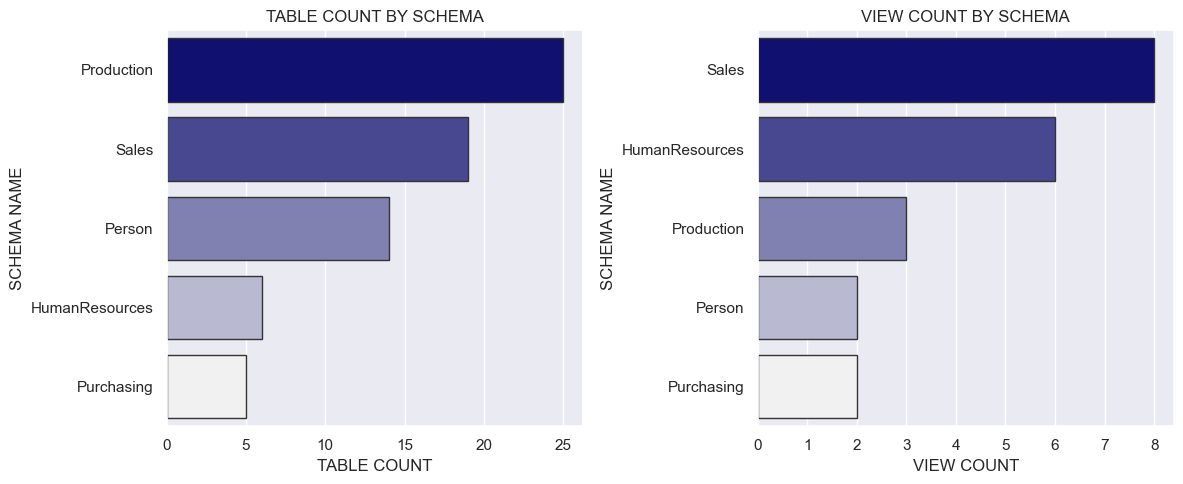

In [3]:
d.plot_schemas()

As can be seen, the Production and Sales schemas are the biggest ones when it comes to the number of tables in them and it seems natural that this would be the case. 

#### The Production schema

The production schema contains various tables related to the products that the company is selling. The largest tables are transaction tables which are used to keep track of among other things work orders and sales transactions. This schema is among the larger ones in the database, both in terms of the number of tables and in terms of row counts in said tables. An overview of the schema and sizes of tables (row count) is shown below.

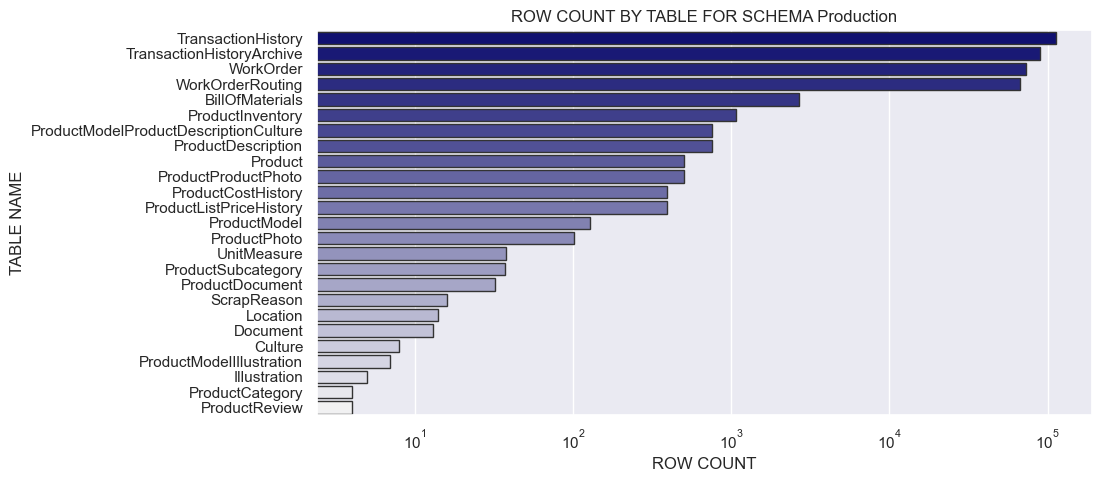

In [4]:
d.plot_schema('Production')

The relations to tables in this schema can be seen below. Here, an arrow from o node $n_1$ to a node $n_2$ indicates that $n_1$ has a foreign key that references a column in $n_2$. A red node indicates that the table does not belong to the Production schema.

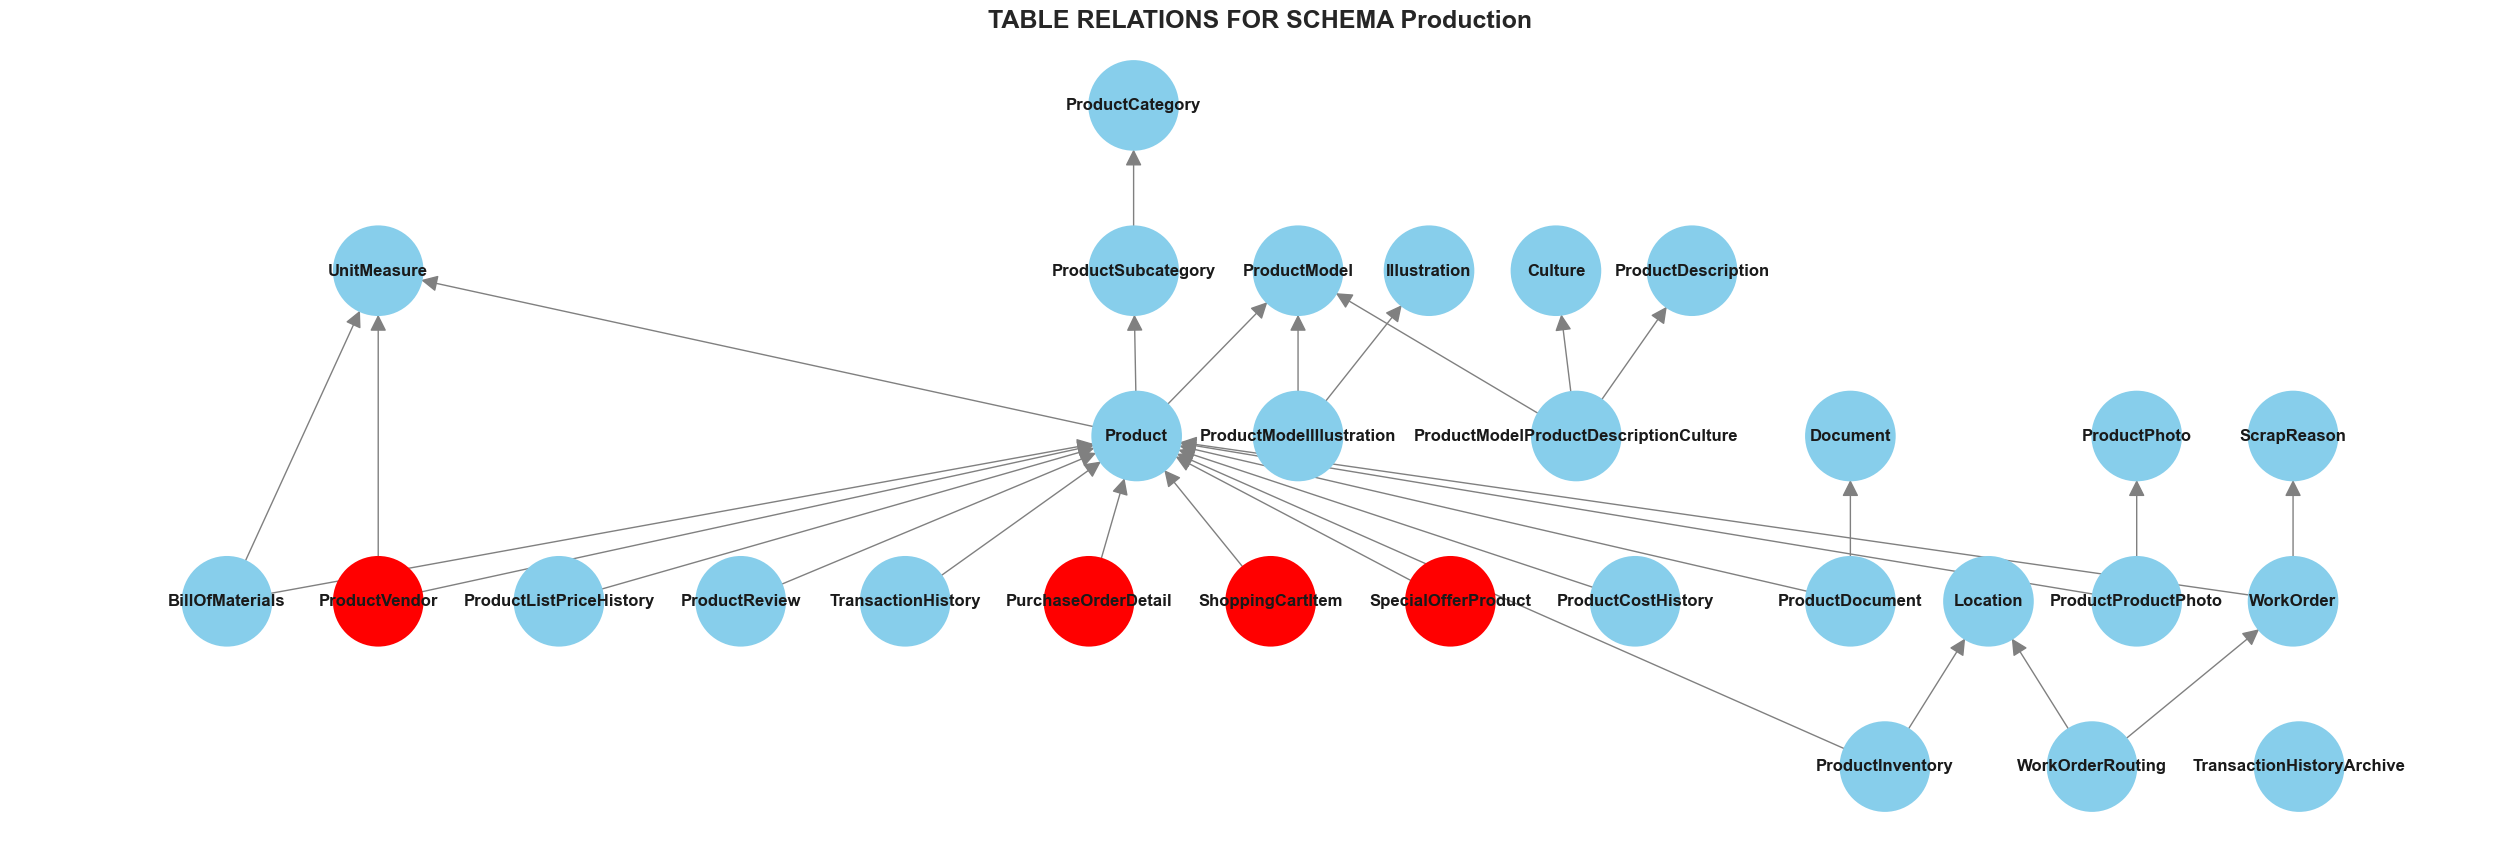

In [5]:
d.plot_schema_relations('Production')

#### The Sales schema

The sales schema (not surprisingly) contains tables related to sales, such as orders, customers, special offers and so on. The biggest tables are the order- and customer tables, which again seems natural. This schema is also one of the larger ones in the database, both in terms of number of tables and row counts in said tables. An overview of the schema may be found below. 

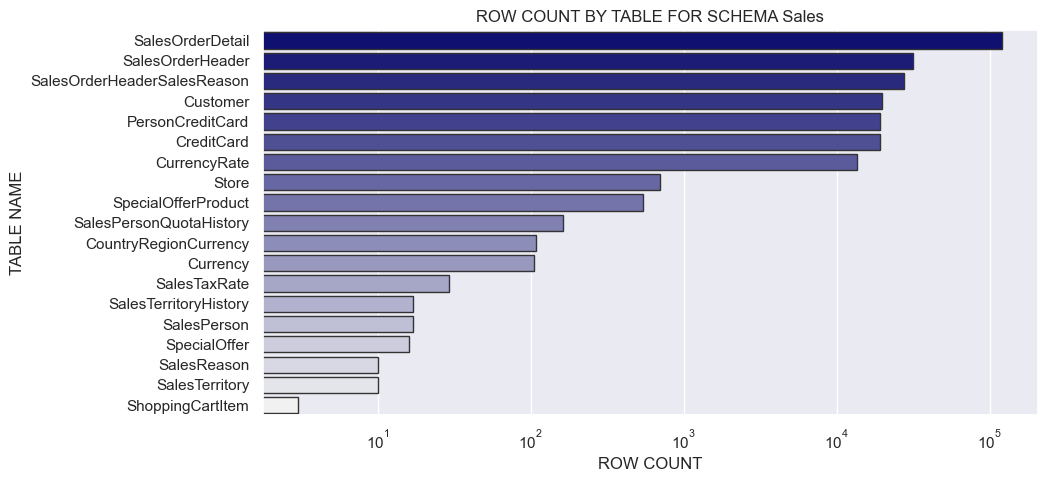

In [6]:
d.plot_schema('Sales')

Relations to tables in this schema are as follows:

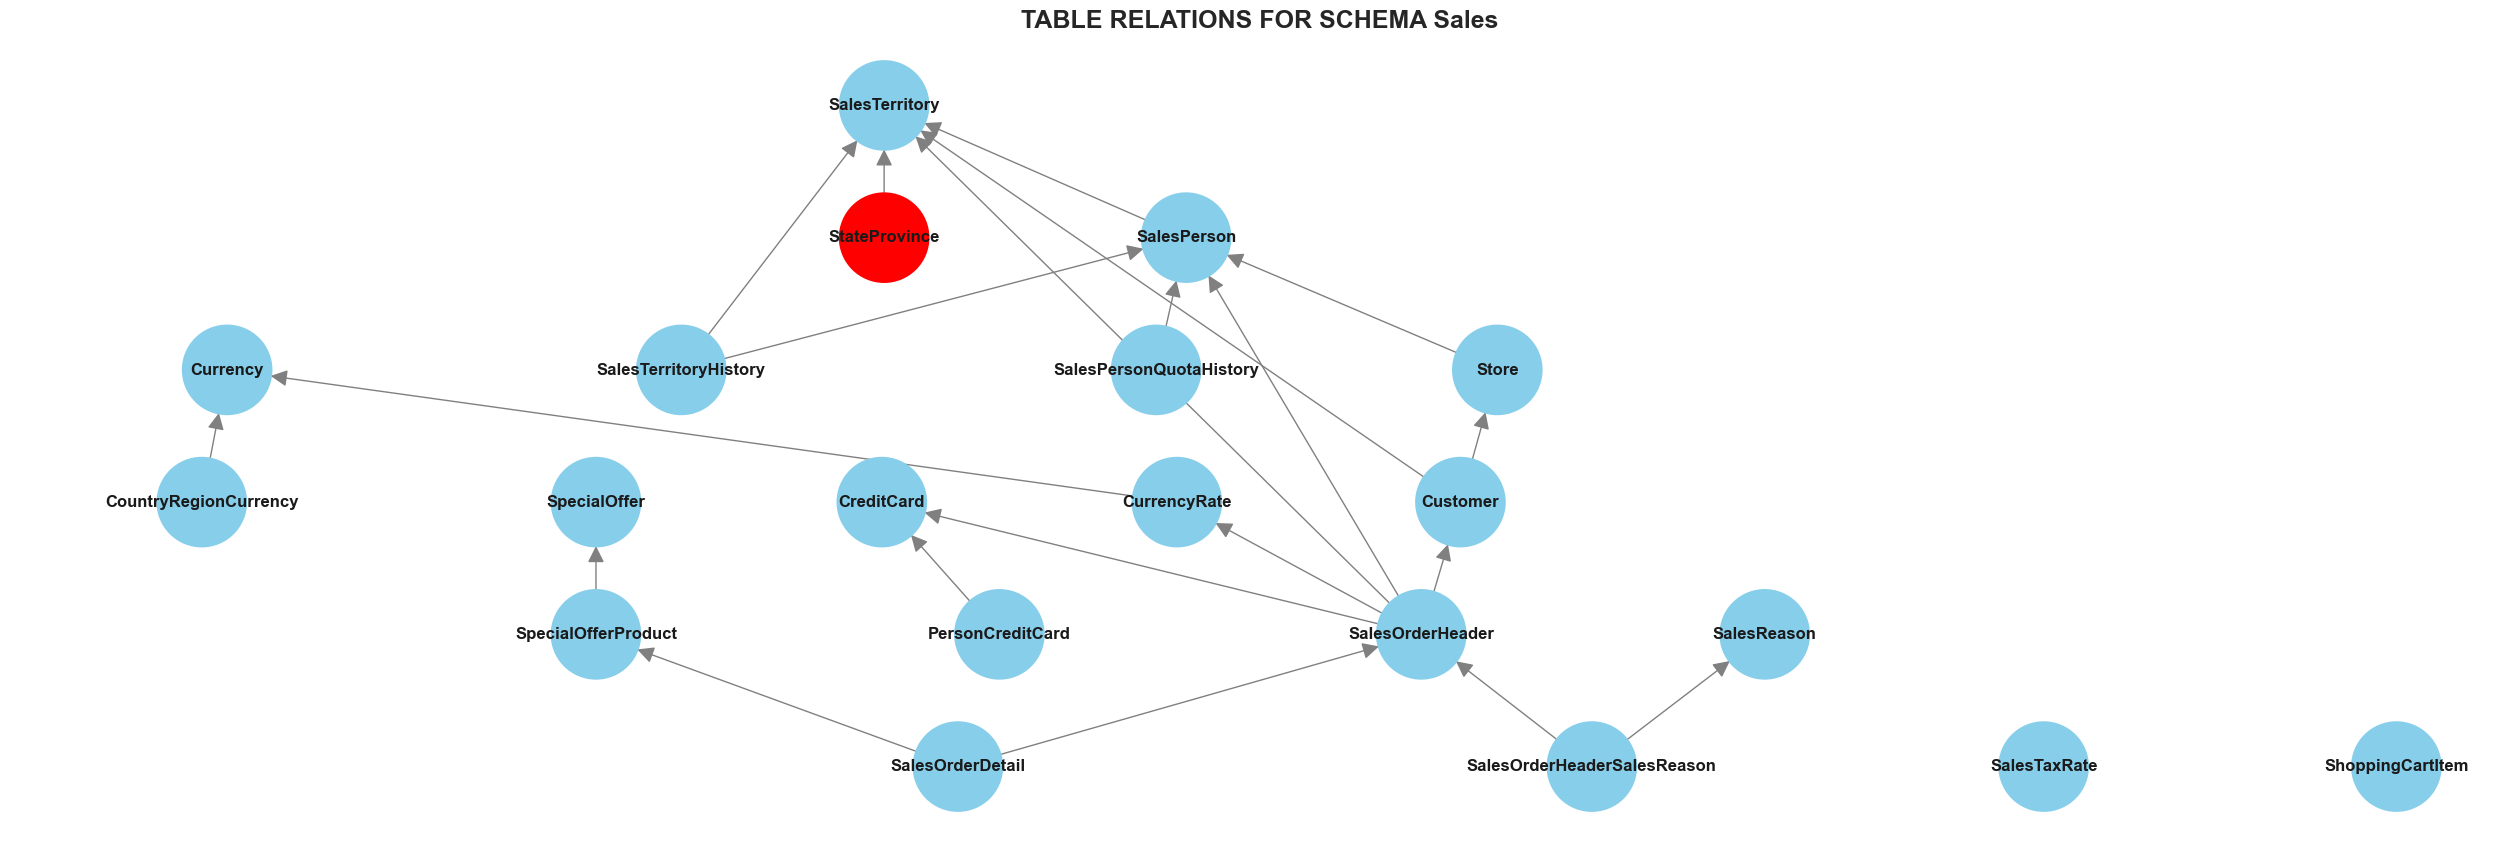

In [7]:
d.plot_schema_relations('Sales')

#### The Person schema

The Person schema contains tables with information regarding all types of persons with some relation to the company, such as employees, customers, suppliers and so on.  This schema contains a fair amount of tables but each table conatins a moderate number of rows. An overview of this schema can be found below. 

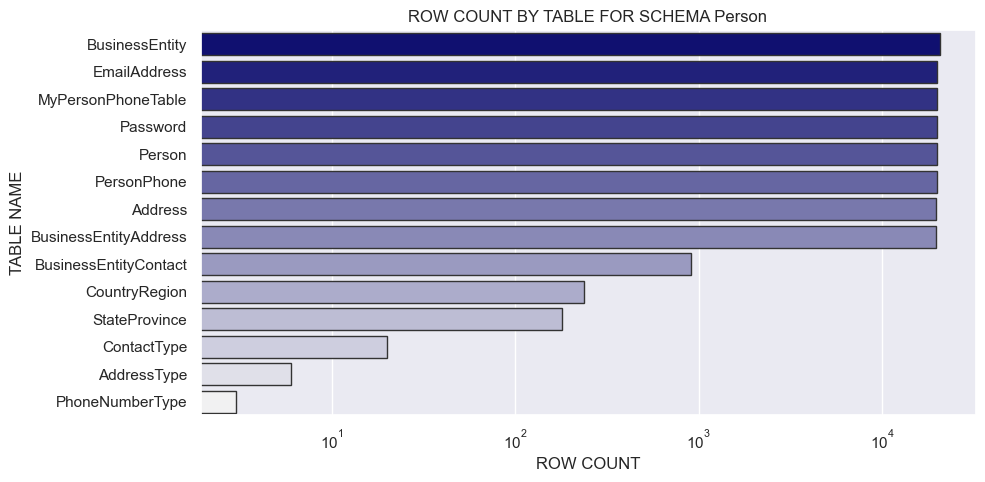

In [8]:
d.plot_schema('Person')

The relations to tables in this schema are as follows

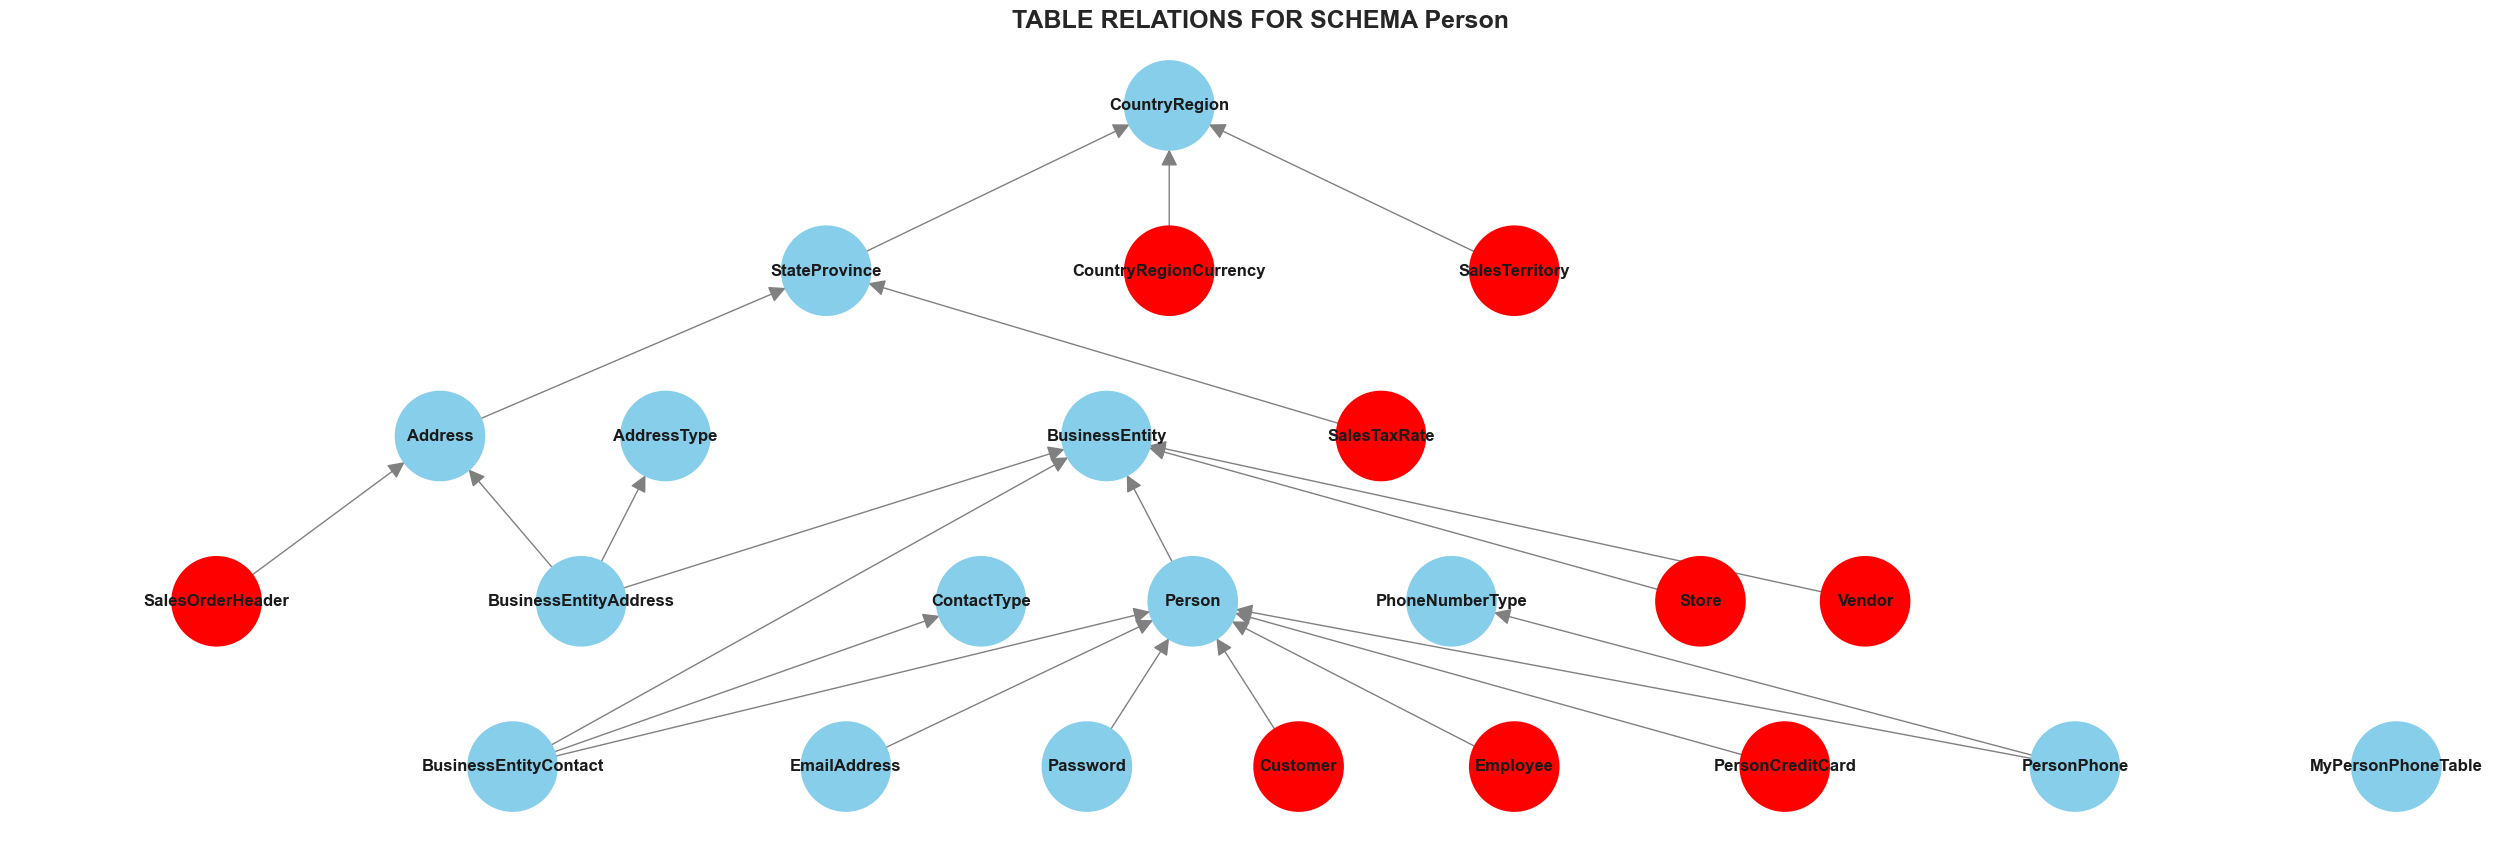

In [9]:
d.plot_schema_relations('Person')

#### The HumanResources schema

The HumanResources schema contains tables with organizational information such as employees departments, salary information and so on. An overview is found below. This schema is rather small, both in terms of number of tables and in terms of row counts in the tables.

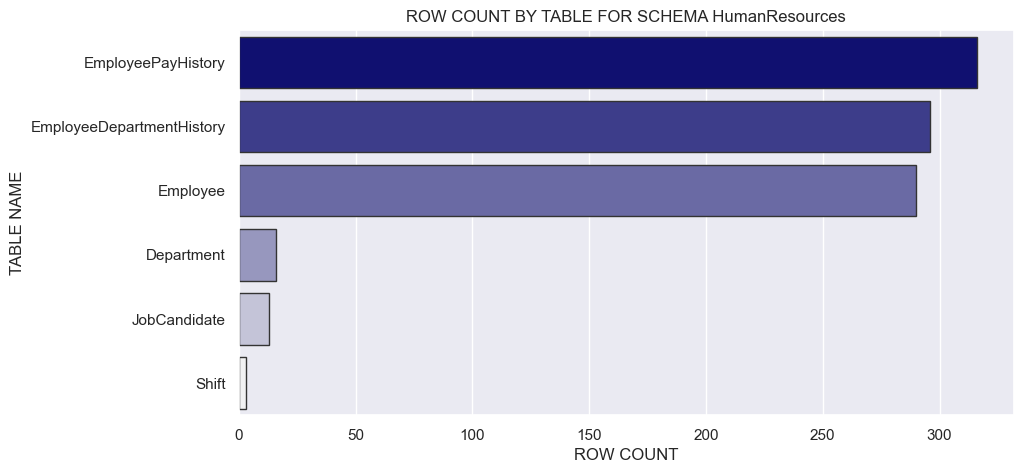

In [10]:
d.plot_schema('HumanResources')

The relations to tables in this schema can be found below.

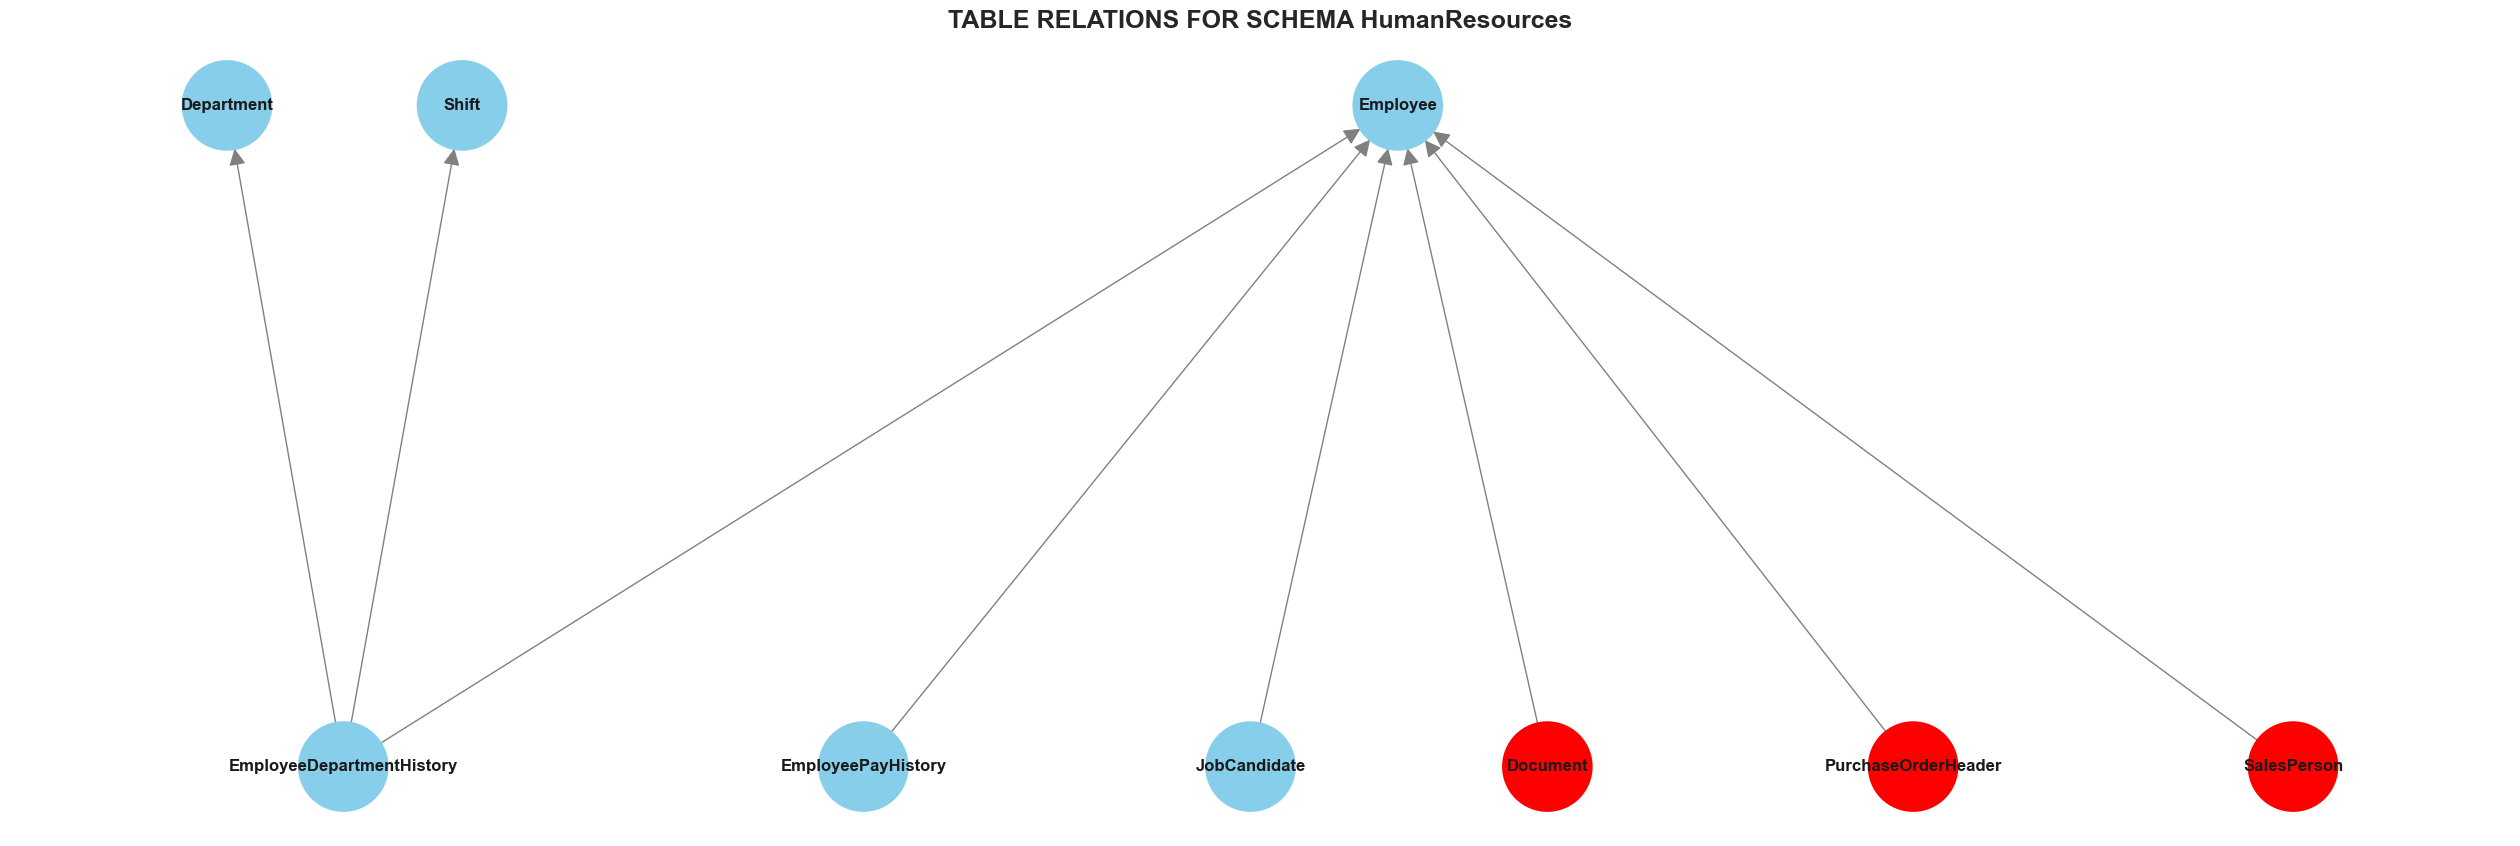

In [11]:
d.plot_schema_relations('HumanResources')

#### The Purchasing schema

The purchasing schema contains tables with information related to purchases that the company has made, such as orders, vendors and shipping details. The schema is among the smaller ones, when it comes to the number of tables and the tables all have a moderate row count.

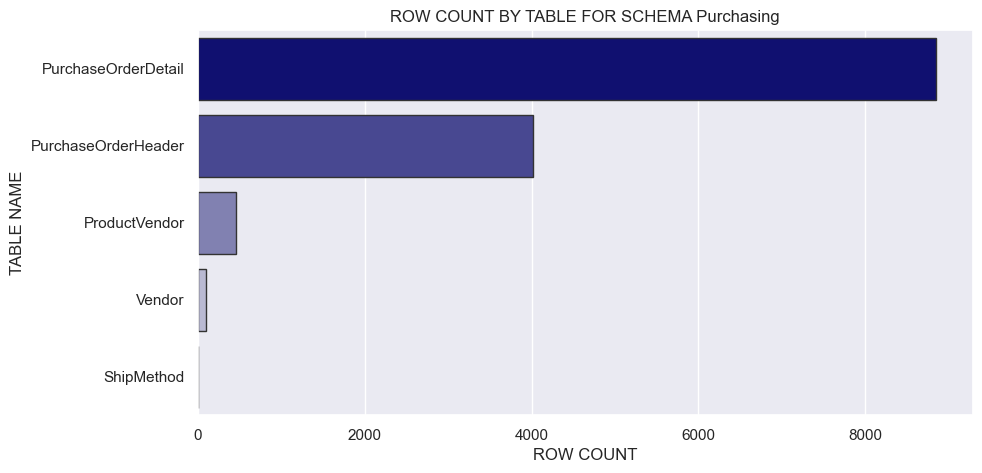

In [12]:
d.plot_schema('Purchasing')

The relations to tables in this schema can be found below.

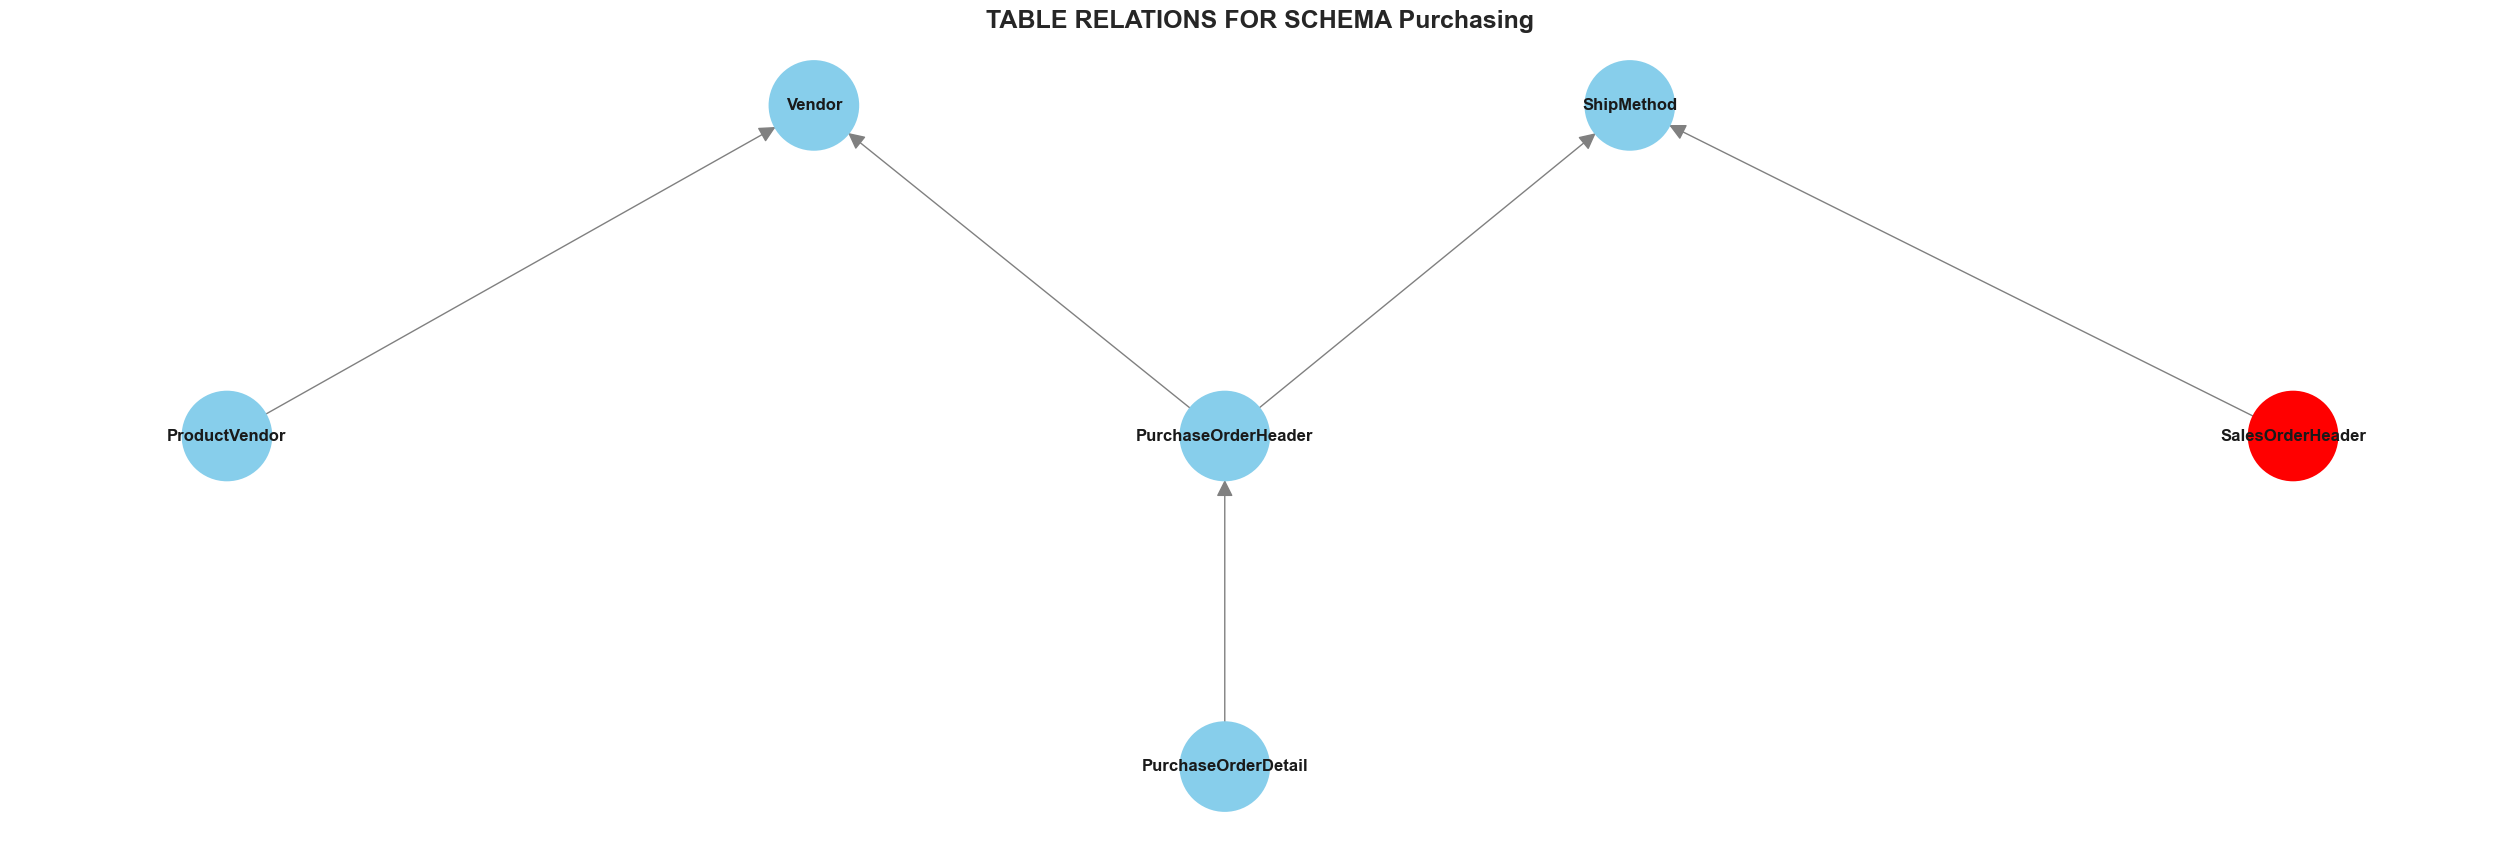

In [13]:
d.plot_schema_relations('Purchasing')

This concludes the database description.

### Statistical Analysis

As before, I present the code blocks first and then use the methods of the CustomerAnalyzer class in the analysis.

#### Code blocks

##### SQL queries

I have chosen to keep the number of joins in the queries low because I want to be able to programmatically validate row counts later on. Therefore, most of the joins will be performed in python by merging dataframes. This is deliberate. 

In [14]:
# A CTE query for creating  the following binary demographic variables for each customer:
#
#   1. AgeLower         1 if the customer is below 50 years old and 0 otherwise
#   2. Married          1 if the customer is married and 0 otherwise
#   3. EducationLower   1 if the education level of the customer is
#                         "Partial High school" or "High school" and 0 otherwise
#   4. IncomeLower      1 if the income level of the customer is "0-25000" or
#                         "25001 - 50000" and 0 otherwise
#   5. GenderFemale     1 if the customer is female and 0 otherwise
#   6. HomeOwner        1 if the customer is a homeowner and 0 otherwise
#   7. CarOwner         1 if the customer owns a car and 0 otherwise
#   8, ChildrenAtHome   1 if the customer has children at home and 0 otherwise
#
# For this query, we use the Sales.Customer and Person.Person tables. In Person.Person, there is
# a Demographics xml column that we can extract the demographic data from.
sql_demographics = """
WITH XMLNAMESPACES ('http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey' AS ns), -- Alias for the Url
/*
    Step 1: Extract demographic data
*/
CustomerDemographics AS(
SELECT
	 T1.CustomerID
	,T2.BusinessEntityID
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:BirthDate)[1]', 'DATE') AS BirthDate -- Such is the syntax for extracting values
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:MaritalStatus)[1]', 'NVARCHAR') AS MaritalStatus
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:YearlyIncome)[1]', 'NVARCHAR(MAX)') AS YearlyIncome
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:Gender)[1]', 'NVARCHAR') AS Gender
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:TotalChildren)[1]', 'INTEGER') AS TotalChildren
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:NumberChildrenAtHome)[1]', 'INTEGER') AS NumberChildrenAtHome
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:Education)[1]', 'NVARCHAR(MAX)') AS Education
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:Occupation)[1]', 'NVARCHAR(MAX)') AS Occupation
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:HomeOwnerFlag)[1]', 'INTEGER') AS HomeOwnerFlag
	,T2.Demographics.value('(/ns:IndividualSurvey/ns:NumberCarsOwned)[1]', 'INTEGER') AS NumberCarsOwned
	,T2.Demographics
FROM
    Sales.Customer T1
INNER JOIN
    Person.Person T2
ON
    T1.PersonID = T2.BusinessEntityID
WHERE
    T2.PersonType = 'IN' -- We only want private individuals
AND
    TerritoryID <= 5 -- We only want US customers
)
/*
    Last step: Convert the demographic data to binary variables.
*/
SELECT
	 CustomerID
	,BusinessEntityID
	,CASE WHEN DATEDIFF(YEAR, BirthDate, GETDATE()) <= 50 THEN '1' ELSE '0' END AgeLower
	,CASE WHEN MaritalStatus = 'M' THEN '1' ELSE '0' END Married
    ,CASE WHEN Education IN ('Partial High School','High School') THEN '1' ELSE '0' END EducationLower
    ,CASE WHEN YearlyIncome IN ('0-25000','25001-50000') THEN '1' ELSE '0' END IncomeLower
    ,CASE WHEN Gender = 'F' THEN '1' ELSE '0' END GenderFemale
	,CAST(HomeOwnerFlag AS NVARCHAR) HomeOwner
	,CASE WHEN NumberCarsOwned > 0 THEN '1' ELSE '0' END CarOwner
	,CASE WHEN NumberChildrenAtHome > 0 THEN '1' ELSE '0' END ChildrenAtHome
FROM
	CustomerDemographics
;
"""

# A query where we simply collect all the orders from the
# Sales.SalesOrderHeader table.
sql_orders ="""
SELECT
     CustomerID
	,SalesOrderID
	,OrderDate
FROM	
    Sales.SalesOrderHeader T2
;
"""

# A query for fetching the reason of sale for each order.
# Here we use the Sales.SalesOrderHeader and 
# Sales.SalesOrderHeaderSalesReason tables. We also create
# a binary variable SalesReasonIDIsAppropriate which is
# 1 if at least one of the reasons for the order  was "Price"
# and/or "Promotion". 
sql_sales_reason = """
SELECT
	  T1.SalesOrderID
      /*
            There can be several sales reasons for one order. Here, we are only
            interested in those orders for which at least one of the  reasons for 
            the sale was "Price" and/or "Promotion". This is why we take the max here.    
      */
	 ,MAX(CASE WHEN ISNULL(T2.SalesReasonID,-1) = 2 OR ISNULL(T2.SalesReasonID,-1) = 1 THEN 1 ELSE 0 END) SalesReasonIDIsAppropriate
FROM
	Sales.SalesOrderHeader T1
LEFT JOIN
	Sales.SalesOrderHeaderSalesReason T2
ON
	T1.SalesOrderID = T2.SalesOrderID
GROUP BY
	T1.SalesOrderID
;
"""

# In this query we fetch content from
# the Sales.SalesOrderDetail table.
sql_order_details = """
SELECT
     SalesOrderID
	,SalesOrderDetailID
	,OrderQty
	,ProductID
	,UnitPrice
	,UnitPriceDiscount
	,LineTotal
FROM
	Sales.SalesOrderDetail
;
"""

# Query for fetching content from the Production.Product and
# Production.ProductSubCategory tables.
sql_products = """
SELECT
     T1.ProductID
	,T1.StandardCost
    ,T1.Name ProductName
    ,T3.Name ProductCategoryName
    ,T2.Name ProductSubCategoryName
FROM
	Production.Product T1
LEFT JOIN
    Production.ProductSubCategory T2
ON
    T1.ProductSubcategoryID = T2.ProductSubcategoryID
LEFT JOIN
    Production.ProductCategory T3
ON
    T2.ProductCategoryID = T3.ProductCategoryID
;
"""

#### The CustomerAnalyzer Class (and one very small exception class)

In [15]:
from tqdm.notebook import tqdm
import numpy as np

# A no content Exception class. We just need to
# define the name of the exception (MergeException)
# this is part of the validation process and we 
# will throw this exception if certain validations
# do not pass.
class MergeException(Exception):
    pass


class CustomerAnalyzer :
    """
    A class for segmenting the existing customers based on available
    demographic data and identify segments that are profitable even at 
    a 40% discount rate.

    Attributes:
        demogr_df:                             pandas.core.frame.DataFrame
        orders_df:                             pandas.core.frame.DataFrame
        sreason_df:                            pandas.core.frame.DataFrame
        orddet_df:                             pandas.core.frame.DataFrame
        prod_df:                               pandas.core.frame.DataFrame
        demord_df:                             pandas.core.frame.DataFrame
        demordsreason_df:                      pandas.core.frame.DataFrame
        demordsreasonorddet_df:                pandas.core.frame.DataFrame
        detailed_data_df:                      pandas.core.frame.DataFrame
        data_df:                               pandas.core.frame.DataFrame
        aggregated_data_df_customer_level:     pandas.core.frame.DataFrame
        aggregated_data_df:                    pandas.core.frame.DataFrame

    """
    def __init__(self,connection_string: str):
        print('Performing various calculations and validations.\nUsually takes about 2.5 - 3 minutes on a decent computer.')
        self.engine = create_engine(connection_string)
        self.__get_dfs__()

    # Create all the dataframes needed for the analysis
    def __get_dfs__(self):
        with self.engine.connect() as conn:
            # fetch needed data from the AdventureWorks database
            self.demogr_df = pd.read_sql(sql_demographics,conn).reset_index(drop=True)
            self.orders_df = pd.read_sql(sql_orders,conn).reset_index(drop=True)
            self.sreason_df = pd.read_sql(sql_sales_reason,conn).reset_index(drop=True)
            self.orddet_df = pd.read_sql(sql_order_details,conn).reset_index(drop=True)
            self.prod_df = pd.read_sql(sql_products,conn).reset_index(drop=True)
            # merge dataframes in a controlled way so that we can perform validation
            # as we go.
            self.__demogr_merge_orders__()
            self.__demord_merge_sreason__()
            self.__demordsreason_merge_orddet__()
            self.__create_data_df_and_detailed_data_df__()
            self.__create_aggregated_data_df__()
    
    # Merge the demogr_df and orders_df dataframes 
    # to form the new dataframe demord_df and perform 
    # validation
    def __demogr_merge_orders__(self):
        self.demord_df = self.demogr_df.merge(
            self.orders_df,
            how='inner',
            on='CustomerID'
        )
        # Perform validation
        if self.demord_df['CustomerID'].unique().shape[0] != self.demogr_df.shape[0]:
            raise MergeException("Number of customer ids changed in the merge between demogr_df and orders_df. This shouldn't happen.")
        
    # Merge the demord_df and sreason_df to form the
    # new dataframe demordsreason_df and perform 
    # validation
    def __demord_merge_sreason__(self):
        self.demordsreason_df=self.demord_df.merge(
            self.sreason_df,
            how='inner',
            on='SalesOrderID'
        )
        # Perform validation
        if self.demordsreason_df['CustomerID'].unique().shape[0] != self.demord_df['CustomerID'].unique().shape[0]:
            raise MergeException(
                "Number of customer ids changed in the merge between demord_df and sreason_df. This shouldn't happen"
            )
        if self.demordsreason_df['SalesOrderID'].unique().shape[0] != self.demord_df['SalesOrderID'].unique().shape[0]:
            raise MergeException(
                "Number of order ids changed in the merge between demord_df and sreason_df. This shouldn't happen"
            )
   
    # Merge the demordsreason_df and orddet_df to form
    # the new dataframe demordsreasonorddet_df and perform
    # validation 
    def __demordsreason_merge_orddet__(self):
        self.demordsreasonorddet_df = self.demordsreason_df.merge(
            self.orddet_df,
            how='inner',
            on='SalesOrderID'
        )
        # Perform validation
        if self.demordsreasonorddet_df['CustomerID'].unique().shape[0] != self.demordsreason_df['CustomerID'].unique().shape[0]:
            raise MergeException(
                "Number of Customer ids changed in the merge between demordsreason_df and orddet_df. This shouldn't happen"
            )
        if self.demordsreasonorddet_df['SalesOrderID'].unique().shape[0] != self.demordsreason_df['SalesOrderID'].unique().shape[0]:
            raise MergeException(
                "Number of order ids changed in the merge between demordsreason_df and orddet_df. This shouldn't happen"
            )
        
    # Merge the demordsreasonorddet_df and prod_df dataframe
    # to form the new dataframe data_df and perform validation.
    # Then add calculated columns Profit and AdjustedProfit.
    # Then compress the binary demographics variables to a 
    # single Label column. Finally, create the dataframe
    # detailed_data_df and clean up the data_df dataframe
    # to only hold necessary columns
    def __create_data_df_and_detailed_data_df__(self):
        self.data_df = self.demordsreasonorddet_df.merge(
            self.prod_df,
            how='inner',
            on='ProductID'
        )

        # Perform validation
        if self.data_df['CustomerID'].unique().shape[0] != self.demordsreasonorddet_df['CustomerID'].unique().shape[0]:
            raise MergeException(
                "Number of Customer ids changed in the merge between demordsreasonorddet_df and prod_df. This shouldn't happen"
            )
        if self.data_df['SalesOrderID'].unique().shape[0] != self.demordsreasonorddet_df['SalesOrderID'].unique().shape[0]:
            raise MergeException(
                "Number of ids changed in the merge between demordsreasonorddet_df and prod_df. This shouldn't happen")
        
        # Add calculated columns
        self.data_df['Profit']=self.data_df['LineTotal']-self.data_df['StandardCost']
        self.data_df['AdjustedProfit']=0.6*self.data_df['LineTotal']-self.data_df['StandardCost']
        
        # compress the binary demographics variables to a 
        # single Label column
        labels = [
            'Married',
            'EducationLower',
            'IncomeLower',
            'GenderFemale',
            'HomeOwner',
            'CarOwner',
            'ChildrenAtHome'
        ]
        label_series=self.data_df['AgeLower'].copy()
        for label in labels:
            label_series+=self.data_df[label]
        self.data_df['Label']=label_series
        
        # Create the detailed_data_df dataframe
        self.detailed_data_df=self.data_df.copy()
        self.detailed_data_df.drop(columns=[
            'AgeLower',
            'Married',
            'EducationLower',
            'IncomeLower',
            'GenderFemale',
            'HomeOwner',
            'CarOwner',
            'ChildrenAtHome'
        ], inplace=True)
        self.detailed_data_df.reset_index(inplace=True,drop=True)

        # Clean up the data_df dataframe
        self.data_df=self.detailed_data_df.loc[
            :,
            [
                'Label',
                'CustomerID',
                'SalesOrderID',
                'SalesOrderDetailID',
                'ProductID',
                'SalesReasonIDIsAppropriate',
                'AdjustedProfit'
            ]
        ].sort_values(by='Label')
        self.data_df.reset_index(inplace=True,drop=True)
    
    # Create the aggregated_data_df dataframe by grouping
    # the data_df dataframe first by OrderID and aggregate,
    # ,then by CustomerID and aggregate and finally on 
    # distinct labels (customersegments)
    # Calculated quantities are:
    #
    # 1. Number of distinct customers
    # 2. Number of distinct orders
    # 3. Numer of products ordered
    # 4. Number of distinct products
    # 5. Aggregated averages of the SalesReasonIDIsAppropriate column
    # 6. Aggregated averages of the AdjustedProfit column
    # 
    # Then add confidence interval lower bounds for the point 
    # estimates AvgAvgSalesReasonIDIsAppropriate and
    # AvgAvgAverageAdjustedProfit. Then filter the dataframe
    # so that we only have segments with a high lower  
    # bound for the SegmentAvgAvgAvgSalesReasonIDIsAppropriate
    # lower bound and at least 50 customers Finally, perform 
    # sorting and index reset.
    def __create_aggregated_data_df__(self):
        # Aggregate on the order level
        df=self.data_df.copy().groupby(
            by=['Label','CustomerID','SalesOrderID'],                
            as_index=False
        ).agg(
            NumOrderDetail = ('SalesOrderDetailID','count'),
            AvgSalesReasonIDIsAppropriate = ('SalesReasonIDIsAppropriate','mean'),
            AvgAdjustedProfit = ('AdjustedProfit','mean')
        )
        # Aggregate on the customer level
        df = df.groupby(
            by=['Label','CustomerID'],
            as_index=False
        ).agg(
            NumOrderDetail = ('NumOrderDetail','sum'),
            NumDistinctOrders = ('SalesOrderID',lambda x:len(set(x))),
            NumDistinctCustomers = ('CustomerID',lambda x:len(set(x))),
            AvgAvgSalesReasonIDIsAppropriate = ('AvgSalesReasonIDIsAppropriate','mean'),
            AvgAvgAdjustedProfit = ('AvgAdjustedProfit','mean')
        )
        # Aggregate on the label level
        df2 = df.groupby(
            by='Label',
            as_index=False
        ).agg(
            SegmentNumOrderDetail = ('NumOrderDetail','sum'),
            SegmentNumDistinctOrders = ('NumDistinctOrders','sum'),
            SegmentNumDistinctCustomers = ('NumDistinctCustomers','sum'),
            SegmentAvgAvgAvgSalesReasonIDIAppropriate = ('AvgAvgSalesReasonIDIsAppropriate','mean'),
            SegmentAvgAvgAvgAdjustedProfit = ('AvgAvgAdjustedProfit','mean')
        )

        # Add confidence interval lower bounds
        df2 = self.__set_conservative_lower_bounds__(
            df,
            df2,
            'AvgAvgSalesReasonIDIsAppropriate',
            'Label'
        )
        df2 = self.__set_conservative_lower_bounds__(
            df,
            df2,
            'AvgAvgAdjustedProfit',
            'Label'
        )

        # Filter
        df2 = df2[df2['SegmentNumDistinctCustomers'] >= 50]
        df2=df2[df2['AvgAvgAvgSalesReasonIDIsAppropriateConservativeCILowerBound'] >= 0.7]

        # Sort and reset index
        df2.sort_values(
            by='AvgAvgAvgAdjustedProfitConservativeCILowerBound',
            ascending=False,
            inplace=True
        )
        df2.reset_index(inplace=True,drop=True)
        
        self.aggregated_data_df_customer_level = df
        self.aggregated_data_df = df2

    # Helper method that, given a base dataframe with a numerical
    # column, an aggregated dataframe for that numerical column
    # and a label column, calculates (CLT and bootstrap) confidence 
    # interval lower bounds for each distinct label in the label column  
    def __set_conservative_lower_bounds__(
        self,
        base_df: pd.core.frame.DataFrame,
        agg_df: pd.core.frame.DataFrame,
        variable: str,
        label: str
    ) -> pd.core.frame.DataFrame:
        # Add CLT lower bounds
        agg_df = self.__set_ci_lower_bounds__(
            base_df,
            agg_df,
            variable,
            label
        )
        #Add bootstrap lower bounds
        agg_df = self.__set_bootstrapped_lower_bounds__(
            base_df,
            agg_df,
            variable,
            label
        )
        agg_df['Avg'+variable+'ConservativeCILowerBound'] = np.minimum(agg_df['Avg'+variable+'CILowerBound'],agg_df['Avg'+variable+'BootstrappedCILowerBound'])
        agg_df.drop(['Avg'+variable+'CILowerBound','Avg'+variable+'BootstrappedCILowerBound'],axis=1,inplace=True)
        return agg_df

    # Helper method that, given a base dataframe with a numerical
    # column, an aggregated dataframe for that numerical column
    # and a label column, calculates (CLT) confidence interval lower
    # bounds for each distinct label in the label column  
    def __set_ci_lower_bounds__(
            self,
            base_df: pd.core.frame.DataFrame,
            agg_df: pd.core.frame.DataFrame,
            variable: str,
            label: str
    ) -> pd.core.frame.DataFrame:
        
        # Create an empty dataframe with two columns:
        #
        # 1. The label column
        # 2. The condfidence interval lower bound column  
        ci_df=pd.DataFrame(columns=[label,'Avg'+variable+'CILowerBound'])
        
        # Iterate over the rows of the aggregated dataframe and fill
        # the newly created dataframe with confidence interval lower
        # bounds.
        for idx,row in agg_df.iterrows():
            observations = base_df[base_df[label]==row[label]][variable].copy()
            average = observations.mean()
            standard_error = np.std(observations,ddof=1)/np.sqrt(len(observations))
            l=average - 1.645 * standard_error
            ci_df.loc[idx] = [row[label],l]
        # Merge the aggregated dataframe with the newly
        # created dataframe
        agg_df=agg_df.merge(ci_df,how='inner',on=label)
        return agg_df

    # Helper method that, given a base dataframe with a numerical
    # column, an aggregated dataframe for that numerical column
    # and a label column, calculates (bootstrap) confidence interval lower
    # bounds for each distinct label in the label column  
    def __set_bootstrapped_lower_bounds__(
            self,
            base_df: pd.core.frame.DataFrame,
            agg_df: pd.core.frame.DataFrame,
            variable: str,
            label: str,
            n_iter: int = 10000
        ):
        print(f'Calculating bootstrapped ci-lower bounds for variable {variable}...')
        # Create an empty dataframe with two columns:
        #
        # 1. The label column
        # 2. The condfidence interval lower bound column  
        ci_df=pd.DataFrame(columns=[label,'Avg'+variable+'BootstrappedCILowerBound'])

        # Iterate over the rows of the aggregated dataframe and fill
        # the newly created dataframe with confidence interval lower
        # bounds.
        lst = [(idx,row) for idx,row in agg_df.iterrows()]
        for idx,row in tqdm(lst):
            observations = base_df[base_df[label]==row[label]][variable].copy()
            avgs = [observations.sample(n=len(observations),replace=True).mean() for i in range(n_iter)]
            l = np.percentile(avgs,5)
            ci_df.loc[idx] = [row[label],l]
        # Merge the aggregated dataframe with the newly
        # created dataframe
        agg_df=agg_df.merge(ci_df,how='inner',on=label)
        print('Done.')
        return agg_df
    
    def get_top_products(self,label: str) -> pd.core.frame.DataFrame:
        """
        A method that creates and returns a dataframe with sales volume and
        profit data for a given market segment. Only products with a sales
        volume larger than 50 is included.

        Arguments:
            label: str (the market segment label)
        Returns:
            df: pd.core.frame.DataFrame
        """
        
        # Create the df with the desired quantities
        df=self.detailed_data_df[self.detailed_data_df['Label'] == label].groupby(
            by=['CustomerID','ProductSubCategoryName'],
            as_index=False
        ).agg(
            NumSold = ('SalesOrderDetailID','count'),
            NumDistinctCustomers = ('CustomerID',lambda x:len(set(x))),
            AvgAdjProfit=('AdjustedProfit','mean')
        )
        
        df2 = df.groupby(
            by='ProductSubCategoryName',
            as_index=False
        ).agg(
            NumSold = ('NumSold','sum'),
            NumDistinctCustomers = ('NumDistinctCustomers','sum'),
            AvgAvgAdjProfit = ('AvgAdjProfit','mean')
        )
        
        # Calculate confidence interval lower bounds for
        # each product sub category
        df2=self.__set_conservative_lower_bounds__(df,df2,'AvgAdjProfit','ProductSubCategoryName')
        # Filter the dataframe on the number of customers
        df2=df2[df2['NumDistinctCustomers'] >= 50]

        # Clean up
        df2.sort_values(by='NumSold',ascending=False,inplace=True)
        df2.reset_index(inplace=True,drop=True)
        
        return df2
    
    def plot_top_five_segments(self):
        """
        A metod for plotting the top 5 customer segments
        in terms of confidence interval lower bounds for
        the profitability measure.
        """

        # Create a dataframe consisting of the data
        # that is to be plotted
        df = self.aggregated_data_df.sort_values(
            by='AvgAvgAvgAdjustedProfitConservativeCILowerBound',
            ascending=False
        ).iloc[:5,:]
        
        # Create a bar chart
        fig,ax=plt.subplots(figsize=(10,5))
        sns.barplot(
            data=df, 
            x='AvgAvgAvgAdjustedProfitConservativeCILowerBound', 
            y=['1','2','3','4','5'],
            palette = sns.light_palette("navy", reverse=False, as_cmap=False,n_colors=5),
            edgecolor=".2",
            hue='AvgAvgAvgAdjustedProfitConservativeCILowerBound',
            legend=False
        )
        # Set axis labels and title
        ax.set_xlabel('Profitability Score Lower Bound')
        ax.set_ylabel('Segment')
        ax.set_title('TOP 5 SEGMENTS AND THEIR PROFITABILITY SCORE LOWER BOUNDS')
        
        # Create a legend containging descriptions of the segment labels in the chart
        legend_entries = ''.join([
            f'{idx+1}: {self.label_to_description(label)}\n' for idx,label in df['Label'].items()
        ])
        plt.annotate(
            legend_entries,
            xy=(0.0, -0.3),
            xycoords='axes fraction',
            ha='left',
            va='center',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white")
        )
        
        # Perform a bit of trickery to make things look well placed
        ax.set_position([0.2, 0.2, 0.7, 0.6])
        plt.tight_layout()
        
        # Show the image
        plt.show()

    def plot_top_five_products(self,label: str):
        """
        A method for plotting, for a specific customer segment, the top selling products
        sub categories within that segments in terms of the number of sold products. 
        Two bar charts are produced: One with the categories and their respective confidence 
        interval lower bounds for the profitability measure, and one with the
        categories and their respective total volume of sales.

        Arguments:
            label: str (the label identifying the segment)
        """
        
        # Create the dataframe containing the data that is to
        # be plotted
        df=self.get_top_products(label)
        
        #Create the plots
        fig,axes=plt.subplots(1,2,figsize=(15,5))
        sns.barplot(
            data=df.sort_values(by='AvgAvgAdjProfitConservativeCILowerBound',ascending=False).iloc[:5,:],
            x='AvgAvgAdjProfitConservativeCILowerBound',
            y='ProductSubCategoryName',
            palette = sns.light_palette("navy", reverse=False, as_cmap=False,n_colors=5),
            edgecolor=".2",
            hue='AvgAvgAdjProfitConservativeCILowerBound',
            legend=False,
            ax=axes[0]
        )
        sns.barplot(
            data=df.sort_values(by='AvgAvgAdjProfitConservativeCILowerBound',ascending=False).iloc[:5,:],
            x='NumSold',
            y='ProductSubCategoryName',
            palette = sns.light_palette("navy", reverse=False, as_cmap=False,n_colors=5),
            edgecolor=".2",
            hue='AvgAvgAdjProfitConservativeCILowerBound',
            legend=False,
            ax=axes[1]
        )
        # Set axis labels and titles
        axes[0].set_xlabel('Profitability Score Lower Bound')
        axes[0].set_ylabel('Product')
        axes[0].set_title('TOP 5 SELLERS AND PROFITABILITY SCORE LOWER BOUNDS (TARGETED SEGMENT)')
        axes[1].set_xlabel('Number of items sold')
        axes[1].set_ylabel('Product')
        axes[1].set_title('TOP 5 SELLERS AND THEIR TOTAL VOLUME OF SALES (TARGETED SEGMENT)')
        
        # Perform a bit of trickery to make things look well placed
        plt.tight_layout()

        # Show the image
        plt.show()
    
    def label_to_description(self,label: str) -> str:
        """
        A method for getting the description for a
        label (market segment label)

        Arguments:
            label: str
        Returns:
            description: str
        """
        description = ''
        if label[0] == '1':
            description+='Age 50 or below'
        else:
            description+='Above age 50'
        if label[1] == '1':
            description+=', married'
        else:
            description+=', unmarried'
        if label[2] == '1':
            description+=', low education'
        else:
            description+=', high education'
        if label[3] == '1':
            description+=', low income'
        else:
            description+=', high income'
        if label[4] == '1':
            description+=' women who '
        else:
            description+=' men who '
        if label[5] == '1':
            description+='own a home and '
        else:
            description+='do not own a home and '
        if label[6] == '1':
            description+='own a car, and who '
        else:
            description+='do not own a car, and who '
        if label[7] == '1':
            description+='have children at home.'
        else:
            description+='do not have children at home.'
        return description

ca=CustomerAnalyzer(f"mssql+pyodbc://localhost/AdventureWorks2022?driver=ODBC+Driver+18+for+SQL+Server&trusted_connection=yes&TrustServerCertificate=yes")

Performing various calculations and validations.
Usually takes about 2.5 - 3 minutes on a decent computer.
Calculating bootstrapped ci-lower bounds for variable AvgAvgSalesReasonIDIsAppropriate...


  0%|          | 0/146 [00:00<?, ?it/s]

Done.
Calculating bootstrapped ci-lower bounds for variable AvgAvgAdjustedProfit...


  0%|          | 0/146 [00:00<?, ?it/s]

Done.


#### A Fictitious scenario

The higher-ups at Adventureworks have a firm beleif in nurturing existing customer relations and in creating a steady flow of new customers. This philosophy applies not only to the big store customers but to private individual customers as well. 

As a consequence, a decision has been made to target 500 existing most valued private individual US-customers and give them a no strings attached, one-time, one-product, but any product 40 % discount. The same is to be done for 500 individuals in the general US-population. At lower levels in the organization, especially among the business analysts, this decision has sparked a discussion about whether it is at all possible to implement this decision in such a way that we can expect to actually make money on the sales with these discounted prices. 

A junior analyst decides to answer this question using a data driven approach where a market segmentation, based on available demographic data, is performed and an investigation of whether there are market segments, where Adventureworks can expect to be profitable even at these highly discounted prices. Below is the result of this analysis.

### Customer Segment Profitability Analysis 

#### Executive summary

The goal of this analaysis is to find at least one segment of the US, private individual market that is profitable even at an across the board 40% discount rate. To this end, we segment this market based on available demographic data in the existing customer data base. These demographics are as follows:

1. Age
2. Marital Status (Single/Married)
3. Education Level
4. Income Level
5. Gender
6. Whether the person is a home owner
7. Whether the person is a car owner
8. Whether the peson has children in the household

We then proceed to calculate two quantities:

1. A profitability score for each segment, the unit of which is USD
2. A price and promotion sensitivity score between 0 and 1 for each segment.

The exact definitions of these measures are found in the detailed analysis. Since the explicitly stated purpose of the discount is to show customer appreciation and to attract new customers, we require the second quantity to be rather high, at least 0.7 at the 95% confidence level, so that we can be relatively confident that those targeted will have good use for the discount. 

It turns out that with these restrictions applied, there is exactly one segment, consisting of 508 customers, that has a positive profatibility score at the 95% confidence level: Above age 50, married, high education, high income men who own a home and a car, and who have children in the household. We recommend that this segment should be targeted for the discount. Below are the top five segments, ordered by their profitability score lower bound, with the discount taken into account. 

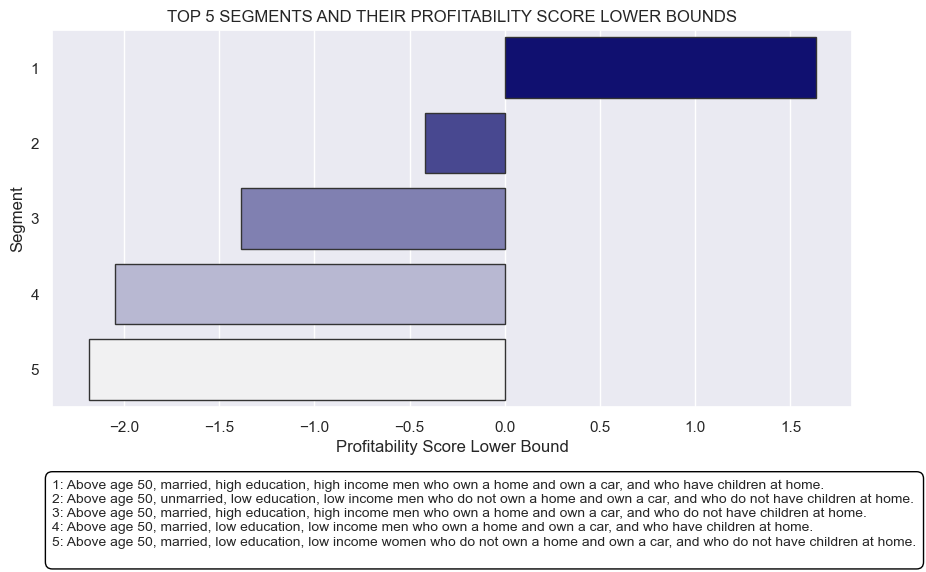

In [16]:
ca.plot_top_five_segments()

Below are the top 5 selling products in the targeted segment and their respective profitability score lower bounds and sales volumes.

Calculating bootstrapped ci-lower bounds for variable AvgAdjProfit...


  0%|          | 0/17 [00:00<?, ?it/s]

Done.


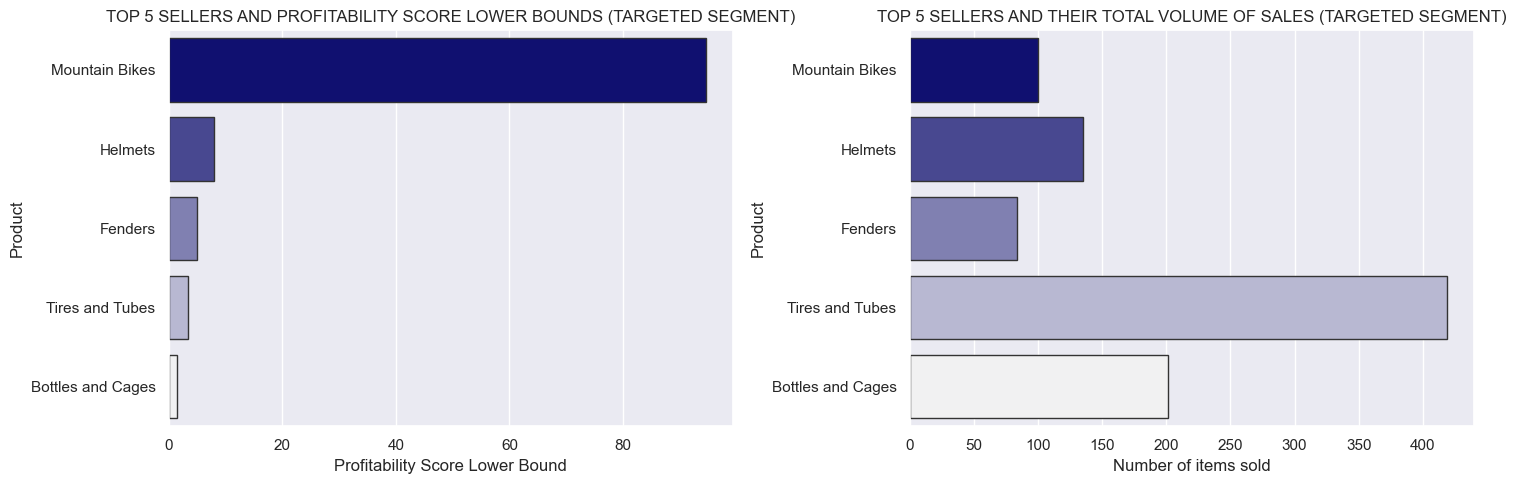

In [17]:
ca.plot_top_five_products('01000111')

Although we refrain from doing so here, further profit optimization could be made by only targeting specific products for the discount.

### Detailed analysis

We begin by performing the segmentation. Using the Sales.Customers and Person.Person tables, we may construct the following dataframe of binary demographics data for US private individual customers:

In [18]:
print(f'Number of rows: {len(ca.demogr_df)}')
ca.demogr_df.head()

Number of rows: 7819


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome
0,13488,2406,0,1,0,0,1,1,1,1
1,25441,2408,0,1,0,1,1,1,1,1
2,29203,2410,0,1,0,0,1,1,0,1
3,17584,2418,0,0,0,0,1,0,1,1
4,24640,2419,0,0,0,1,1,0,1,0


We are going to need some form of measure of responsiveness to price and promotion within each market segment. Using the tables Sales.SalesOrderHeader and Sales.SalesOrderHeaderSalesReason, we construct a binary variable SalesReasonIDIsAppropriate which takes the value 1 if one of the reasons for the sale was "Price" or "Promotion" and 0 otherwise. We will later use this variable to define the price and promotion sensitivity measure. The updated dataframe looks like this: 

In [19]:
print(f'Number of rows: {len(ca.demordsreason_df)}')
ca.demordsreason_df.head()

Number of rows: 9567


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome,SalesOrderID,OrderDate,SalesReasonIDIsAppropriate
0,13488,2406,0,1,0,0,1,1,1,1,60009,2013-11-12,1
1,25441,2408,0,1,0,1,1,1,1,1,56393,2013-09-18,1
2,29203,2410,0,1,0,0,1,1,0,1,45241,2011-12-28,0
3,29203,2410,0,1,0,0,1,1,0,1,61589,2013-12-05,1
4,17584,2418,0,0,0,0,1,0,1,1,75047,2014-06-28,1


We see now that the number of rows has increased, which is natural since one customer can have many orders. We will also need a measure of profitability within each segment. To construct such a measure, we need detailed data about the contents of the order such as order quantities, product ids and prices. This information can be found in the Sales.SalesOrderDetail table. The updated dataframe has the following appearance: 

In [20]:
print(f'Number of rows: {len(ca.demordsreasonorddet_df)}')
ca.demordsreasonorddet_df.head()

Number of rows: 21344


,CustomerID,BusinessEntityID,AgeLower,Married,EducationLower,IncomeLower,GenderFemale,HomeOwner,CarOwner,ChildrenAtHome,SalesOrderID,OrderDate,SalesReasonIDIsAppropriate,SalesOrderDetailID,OrderQty,ProductID,UnitPrice,UnitPriceDiscount,LineTotal
0,13488,2406,0,1,0,0,1,1,1,1,60009,2013-11-12,1,72834,1,878,21.98,0.0,21.98
1,13488,2406,0,1,0,0,1,1,1,1,60009,2013-11-12,1,72835,1,876,120.00,0.0,120.00
2,25441,2408,0,1,0,1,1,1,1,1,56393,2013-09-18,1,58855,1,922,3.99,0.0,3.99
3,25441,2408,0,1,0,1,1,1,1,1,56393,2013-09-18,1,58856,1,933,32.60,0.0,32.60
4,25441,2408,0,1,0,1,1,1,1,1,56393,2013-09-18,1,58857,1,711,34.99,0.0,34.99


We note that again, the number of rows has increased, which is to be expected since one order can have many line items. It is important to investigate the contents of the OrderQty and UnitPrice columns since these will affect how we calculate the profits. The minimum and maximum values of these are shown below:

In [21]:
print(f'OrderQty minimum: {ca.demordsreasonorddet_df.OrderQty.min()}')
print(f'OrderQty maximum: {ca.demordsreasonorddet_df.OrderQty.min()}')
print(f'UnitPriceDiscount minimum: {ca.demordsreasonorddet_df.UnitPriceDiscount.min()}')
print(f'UnitPriceDiscount maximum: {ca.demordsreasonorddet_df.UnitPriceDiscount.max()}')

OrderQty minimum: 1
OrderQty maximum: 1
UnitPriceDiscount minimum: 0.0
UnitPriceDiscount maximum: 0.0


It turns out that these columns both have constant values and so we don't need to take them into account. We need one more piece of data to be able to perform the analysis: The cost of each product. This information is available in the Production.Product table via the StandardCost column. We add this column to our dataframe. Then we define the measure AdjustedProfit as 0.6 * LineTotal - StandardCost. This measure takes into account the 40% discount. We compress the demographics column into a single column using concatenation to form a segment label and remove columns we don't need. The final dataframe (sorted on labels) containing the data we need now looks as follows:

In [22]:
print(f'Number of rows: {len(ca.data_df)}')
ca.data_df.head()

Number of rows: 21344


,Label,CustomerID,SalesOrderID,SalesOrderDetailID,ProductID,SalesReasonIDIsAppropriate,AdjustedProfit
0,00000000,29166,59258,70948,870,1,1.1277
1,00000000,12414,58709,66984,876,0,27.1200
2,00000000,27202,54115,51687,880,1,12.4277
3,00000000,27018,64133,85907,934,1,6.5517
4,00000000,26299,72927,116063,934,1,6.5517


As can be seen, the number of rows has not changed, which is as it should be. We also note that there are rows with a negative profit. These are rows where the product sold is such that we actually loose money by giving a 40% reduction in price. We want to examine if there are any segments, where we can expect to make money even with the 40% reduction in price. There is one important thing to note here: The dataset has a hierachical structure. One customer can have many orders and one order has many products in it. It is not overly paranoid to suspect that there are intra level dependencies. For instance, perhaps it is more likely that you buy a pump, given that you buy a tyre under one and the same order. It may be the case that customers have repeated orders containing the same products. As a consequence, we cannot consider the AdjustedProfit and SalesReasonIDIsAppropriate columns of our dataframe to be i.i.d samples at the lowest levels in the hierarchy and so the central limit theorem may not apply for the calcualation of condidence intervals. To destroy intra level dependencies and end up with (close to) i.i.d samples of measures at the customer level, we proceed as follows:

1. Group at the order level and calculate the average adjusted profit and average SalesReasonIDIsAppropriate and produce a new dataframe at this level

2. Group the new dataframe at the customer level and calculate "Averages of averages" and produce a new dataframe at this level

3. The measures can now be calculated at the segment level as averages since the values at the customer level are (close to) i.i.d

4. Calculate lower bounds for these two measures at the 95% confidence level. Since there has been a bit of trickery involved, we calculate lower bounds using both the central limit theorem and by bootstrapping. We then conservatively choose the lowest of these bounds to be the bound under consideration.

We require there to be at least 50 customers in the segment to ensure central limit theorem applicability for the calculation of lower bounds. Also, we want our chosen customers to actually use the discount, because only then, can we be relatively certain that the "softer" intentions of the discount, such as the customer feeling appreciated, will be achieved. We therefore require the lower bound for price and promotion sensitivity to be at least 0.7. 

With these calculations and restrictions applied, the aggregated data is shown below (sorted by profitability lower bound in descending order):

In [23]:
print(f'Number of rows: {len(ca.aggregated_data_df)}')
ca.aggregated_data_df#.head(10)

Number of rows: 21


,Label,SegmentNumOrderDetail,SegmentNumDistinctOrders,SegmentNumDistinctCustomers,SegmentAvgAvgAvgSalesReasonIDIAppropriate,SegmentAvgAvgAvgAdjustedProfit,AvgAvgAvgSalesReasonIDIsAppropriateConservativeCILowerBound,AvgAvgAvgAdjustedProfitConservativeCILowerBound
0,01000111,1365,618,508,0.786417,3.313902,0.759575,1.632649
1,00110010,137,62,60,0.883333,1.346887,0.816667,-0.420727
2,01000110,1040,449,361,0.760388,1.024039,0.727147,-1.386972
3,01110111,127,57,52,0.846154,0.896021,0.759615,-2.047508
4,01111010,117,55,52,0.855769,0.180193,0.769231,-2.184388
5,01001111,1239,552,434,0.778802,-1.047213,0.750000,-2.992297
6,01110010,127,55,54,0.861111,-1.066296,0.777778,-3.192163
7,01000011,136,60,50,0.880000,4.251341,0.810000,-3.311469
8,01100111,192,83,74,0.817568,0.399117,0.743243,-3.662597
9,01001110,1131,494,400,0.750000,-1.471928,0.717500,-3.672461


As can be seen, there are several segments for which the point estimate for the profitability measure is positive. Only one segment survives the lower bound requirement though: the segment with label '01000111'. Why is that? Because the variability in other segments is higher than in our targeted one. Let's do a quick ad hoc analysis and compare the standard errors (which is a measure of variability) for the "surviving" label 01000111 and the label 01000011 which has an even higher point estimate than that of the surviving label:

In [24]:
def print_variability(label):
    df=ca.aggregated_data_df_customer_level
    df=df[df['Label']==label]
    standard_error = df['AvgAvgAdjustedProfit'].std(ddof=1)/np.sqrt(len(df))
    print(f"Standard error for AvgAvgAdjustedProfit - label {label}: {standard_error}")
    print(f"Confidence interval lower bound - label {label}: {df['AvgAvgAdjustedProfit'].mean()-1.645*standard_error}\n")
label = '01000111'
print_variability(label)
label = '01000011'
print_variability(label)

Standard error for AvgAvgAdjustedProfit - label 01000111: 1.0220382318751657
Confidence interval lower bound - label 01000111: 1.6326490081716543

Standard error for AvgAvgAdjustedProfit - label 01000011: 4.597453096646907
Confidence interval lower bound - label 01000011: -3.3114693273175



The differences are indeed due to intra segment variability. Below is a desription of the surviving segment:

In [25]:
ca.label_to_description('01000111')

'Above age 50, married, high education, high income men who own a home and own a car, and who have children at home.'

To those who have, more shall be given, it would seem. What products then, should we expect to sell in our targeted "alpha male" segment?

In [26]:
ca.get_top_products('01000111')

Calculating bootstrapped ci-lower bounds for variable AvgAdjProfit...


  0%|          | 0/17 [00:00<?, ?it/s]

Done.


,ProductSubCategoryName,NumSold,NumDistinctCustomers,AvgAvgAdjProfit,AvgAvgAdjProfitConservativeCILowerBound
0,Tires and Tubes,419,236,3.619273,3.405617
1,Bottles and Cages,201,129,1.501739,1.455007
2,Helmets,135,134,7.907700,7.907700
3,Road Bikes,114,114,-46.839325,-55.586188
4,Mountain Bikes,100,100,102.116896,94.380349
5,Fenders,84,84,4.967500,4.967500
6,Jerseys,77,77,-8.798560,-8.862276


We see that tires and tubes are the top sellers. We also note that among these top sellers there are products with a negative lower bound for the profit. These, however, are compensated for by the products with positive lower bound and we arrive at a positive estimated lower bound for the segment as a whole. This concludes the detailed analysis.

### Meta analysis (caveats and considerations)

We have found a market segment that is profitable, even at a discount rate of 40%. This market segment consists of men who have come of age and who are successful at life. They own high cost assets such as houses and cars. It does seem plausible that such a market segment can and will purchase products where we have a high enough profit margin to sustain profitability, even with significant discounts.  

Great care has been taken to ensure that the obtained lower bounds for the calculated measures are valid by mitigating intra level dependencies in the hierarchical data and by computing confidence interval lower bounds in two different ways and conservatively choosing the lower of the two. As with any statistical analysis however, there are considerations and caveats to be made. Here are a few:

1. If, for some reason, the customers and patterns of purchase in our database is not a representative sample of the market, the conclusion made in this analysis may not hold true. We do however, have the odds on our side that this is not the case, since we are dealing with a large enough sample that the probability of producing a pathological sample of that size is low.

2. There is a possibility that the 40% discount will change the distribution of sales volumes over the product categories. Given a 40% discount, you may not go for "Tires and tubes", but rather for more expensive products such as bikes. We deem it unlikely that the distribution within the "Bike" category changes much though and since this category is evenly distributed over Road Bikes (-55 USD lower bound for average profit) and Mountain bikes (94 USD lower bound for average profit) we should be profitable, even if there is such an effect.

3. The profitability measure (and price/promotion-sensitivity measure for that matter) cannot strictly be interpreted as "Expected profit per customer in the segment". This is due to the hierachical nature of the data. We have used aggregated averages in order to obtain trustworthy lower bounds. Nonetheless, the calculated measures are robust indicators of profitability and price/promotion sensitivity.

We conclude the meta analysis with the observation that further profitablility optimizations can be made by restricting which product categories are part of the offered discount, but since the discount is to be given "across the board", we refrain from doing so here.

## Självvärdering

### Utmaningar under arbetet

Den största utmaningen var att fundera ut vad jag ville göra för statistisk analys. Det finns så mycket intressant data att titta på i databasen så möjligheterna är nästan obegränsade. I slutändan valde jag att skapa ett någorlunda realistiskt scenario som jag tänkte att ett företag definitivt skulle analysera: Lönsamhet inom olika kundsegment. En annan utmaning har varit att lära mig vad jag behövde lära mig för att kunna använda networkx för att rita relationsdiagram. Jag har aldrig tidigare använt detta paket (bara känt till det) så det satt jag med ett tag innan jag fick rätt på det. Slutligen var det en utmaning (dels att inse (vilket hände ganska sent) och sedan att luska ut hur jag skulle hantera det) att datasetet (på grund av dess hierarkiska struktur) nästan säkert inte kunde anses vara ett i.i.d stickprov. Här fick jag bekanta mig med att aggregera aggregeringar (vilket många gånger är att betrakta som en synd) för att elliminera beroenden inom lägre nivåer i hierarkin och bootstrap konfidensintervall för att kunna välja konservativa lägre gränser för de mått jag använde. Allt som allt väldigt lärorikt. 

### Betyg jag anser att jag ska ha

I min bok förtjänar jag ett VG (om inte för annat så åtminstone för mängden nedlagt arbete :) ). Det finns betydligt enklare analyser man kan göra än den jag valde att göra. Jag har reflekterat över de metoder jag använt och belyst både styrkor och svagheter. Koden är väldokumenterad.  

### Tips till mig själv

1. Reflektera på ett tidigare stadium om de teoretiska förutsättningarna för de statistiska beräkningarna är uppfyllda och hur det ska hanteras om de inte är uppfyllda. Detta är nog den viktigaste lärdomen.

2. Skapa först en "road map" för analysen och håll dig till den. Man riskerar att sväva ut för mycket annars. "Det här skulle man också kunna ta med. Och det här. Och det här"-impulsen är stark. 

3. Snygga diagram bör kanske prioriteras ned något i förhållande till andra saker...